Мы располагаем данными из открытых источников о продажах игр. Чтобы выявить закономерности определяющие успешность игры, мы проанализируем эти данные ниже. Нам в первую очередь необходимо найти потенциально популярный продукт, чтобы сделать на него ставку.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from pylab import rcParams


## Загрузка файла

In [2]:
try:
    data = pd.read_csv('D:\Яндекс Практикум\games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

## Подготовка данных

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Название столбцов

Приведем названия столбцов к нижнему регистру

In [4]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [5]:
# Пройдемся по каждому названию и приведем каждое к нижнему регистру
for column in data.columns:
    data = data.rename(columns={column:column.lower()})

### Пропуски

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Описание даннных**

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг - компьютерных игр и присваивает им подходящую возрастную категорию.

Столбцы name, genre скорее всего будут вместе отсутствовать. Посмотрим на строки с пропусками в них.

In [7]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


У них отсутствует очень много информации. Думаю можно удалить именно эти строки.

In [9]:
cleared_data = data.dropna(subset=['year_of_release', 'name', 'genre']).copy()

Думаю можно заменить год релиза на год последней игры выпущенной на платформе. 

In [10]:
for platform in cleared_data['platform'].unique():
    cleared_data.loc[(cleared_data['platform'] == platform) & (cleared_data['year_of_release'].isna()), 'year_of_release'] = (
        cleared_data.groupby(['platform'])['year_of_release'].max()[platform]
    )

Дальше посмотрим user_score, потому что у него даже выделяющийся тип данных. 

In [11]:
cleared_data['user_score'].describe()

count     9839
unique      96
top        tbd
freq      2376
Name: user_score, dtype: object

In [12]:
cleared_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Рейтинг ESRB действителен в первую очередь для Америки, для Европы и Японии используются преимущественно другие рейтинги. Потому здесь пропуски это нормально, заменим их на 'tbd'.

In [13]:
# Замена пропусков в рейтинге игр на tbd
cleared_data.loc[:,'rating'] = cleared_data['rating'].fillna('tbd').copy(deep=False)

Заменим 'tbd' из 'user_score' на 'nan'. В данном случае это одно и то же.

In [14]:
cleared_data.loc[cleared_data['user_score'] == 'tbd', 'user_score'] = np.nan

In [15]:
cleared_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Теперь посмотрим столбцы с рейтингом и оценками вместе. Они должны быть очень близки и значения можно будет сопоставить.

In [16]:
cleared_data[['critic_score', 'user_score', 'rating']]

,critic_score,user_score,rating
0,76.0,8,E
1,NaN,NaN,tbd
2,82.0,8.3,E
3,80.0,8,E
4,NaN,NaN,tbd
...,...,...,...
16710,NaN,NaN,tbd
16711,NaN,NaN,tbd
16712,NaN,NaN,tbd
16713,NaN,NaN,tbd


Похоже что есть строки, где все значения отсутствуют. 

In [17]:
cleared_data[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna())].shape[0]

1089

Получается есть строки, где присутствует оценка от критиков, но не от пользователей.

In [18]:
cleared_data[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna())].shape[0]

569

А также есть и строки, где почему то отсутствуют оценки от критиков. 

Оценим корреляцию оценки критиков и пользователей.

In [19]:
(
    pd.to_numeric(cleared_data['critic_score'])
    .corr(pd.to_numeric(cleared_data['user_score'], errors='coerce') * 10)
)

0.5796706281932215

Довольно высокий коэффициент. Думаю можно тогда заменить отсутствующие значения в одном подменой на значение из другого столбца.

In [20]:
# Я просто заменяю отсутствующие значения в оценке критиков на те, что присутствуют в оценке пользователей
cleared_data.loc[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna()), 'critic_score'] = (
    pd.to_numeric(
        cleared_data.loc[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna()), 'user_score']
    ) * 10
)

In [21]:
# То же, но только отсутствуюшие оценки пользователей на оценки критиков
cleared_data.loc[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna()), 'user_score'] = (
    pd.to_numeric(
        cleared_data.loc[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna()), 'critic_score']
    ) / 10
)

Остальные значения оставим пустыми.

### Приведение к нужному типу

Надо поменять year_of_release на int (потому что год это целое число), critic_score на int (потому что оценка критика это число от 0 до 100) и user_score на float (из-за одного значения столбец был объектовым, но теперь нужно поменять на число с плавающей точкой).

In [22]:
cleared_data = cleared_data.convert_dtypes(convert_string=False)

Функция автоматически заменяет, потому проверим.

In [23]:
cleared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  Float64
 5   eu_sales         16444 non-null  Float64
 6   jp_sales         16444 non-null  Float64
 7   other_sales      16444 non-null  Float64
 8   critic_score     8552 non-null   Int64  
 9   user_score       8552 non-null   object 
 10  rating           16444 non-null  object 
dtypes: Float64(4), Int64(2), object(5)
memory usage: 1.6+ MB


user_score - не поменял тип, потому сделаем вручную это.

In [24]:
cleared_data['user_score'] = pd.to_numeric(cleared_data['user_score'], errors='coerce')

In [25]:
cleared_data['user_score'].dtype

dtype('float64')

Заменим отсутствующие значения на tbd.

In [26]:
cleared_data['rating'].fillna('tbd', inplace=True)

### Продажи по регионам

In [27]:
cleared_data['total_sales'] = (
    cleared_data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
)

## Исследовательский анализ

In [28]:
# Поменяем стиль на что-то более приятное
plt.style.use('seaborn')
rcParams['figure.figsize'] = 18, 8

### Продажи по годам

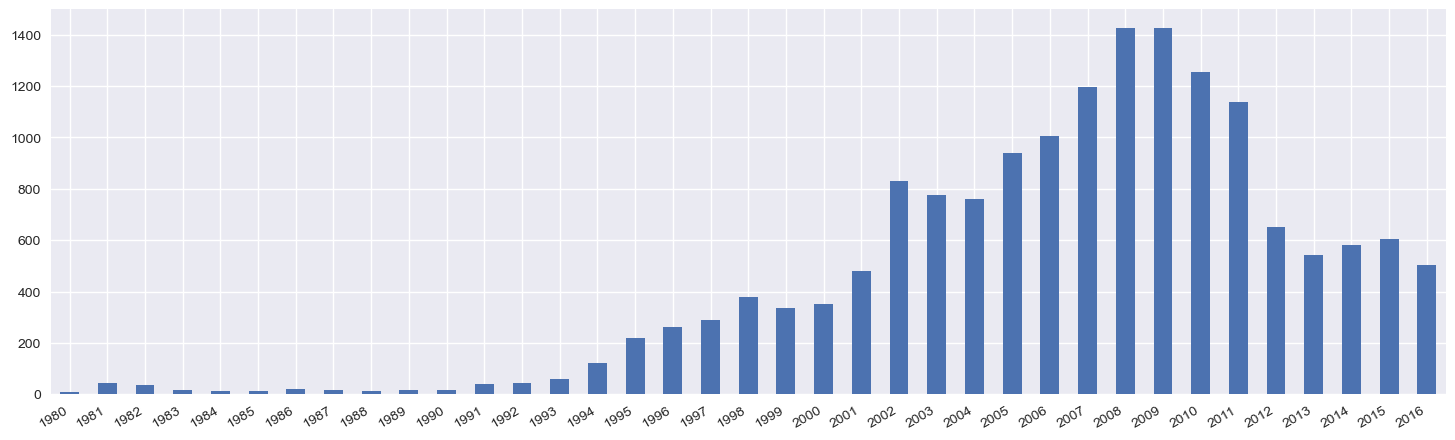

In [29]:
(
    cleared_data['year_of_release']
    .value_counts()
    .sort_index()
    .plot(kind='bar', figsize=(18,5))
);
plt.xticks(rotation=30, horizontalalignment='right');

По графику видно, что после 90-х выпускали все больше и больше игр с каждым годом. В 9-ом году был пик популярности и дальше пошла стабилизация выпуска игр.

Думаю данные можно брать после 94-го года, так как до него .

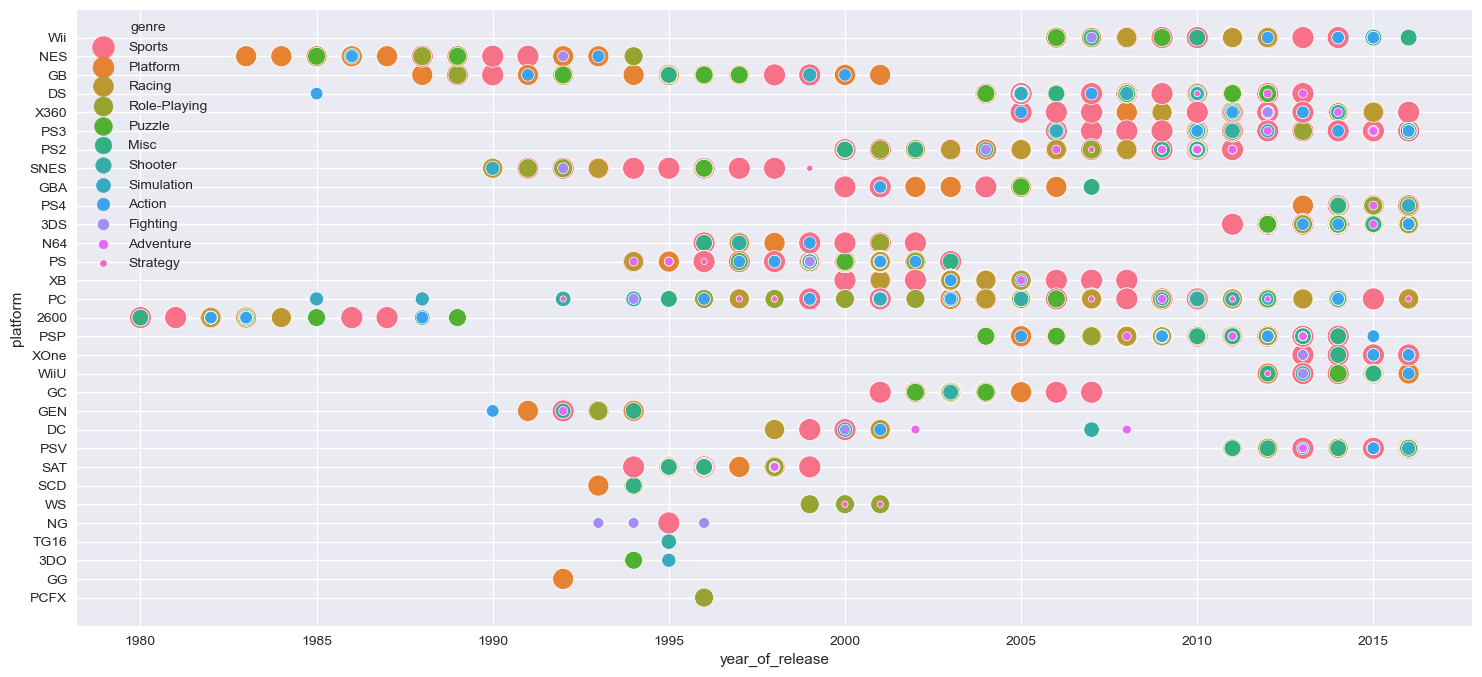

In [30]:
sns.scatterplot(
    x='year_of_release', y='platform',
    hue='genre', size='genre',
    data=cleared_data,
    sizes=(20, 250)
);

### Продажи по платформам

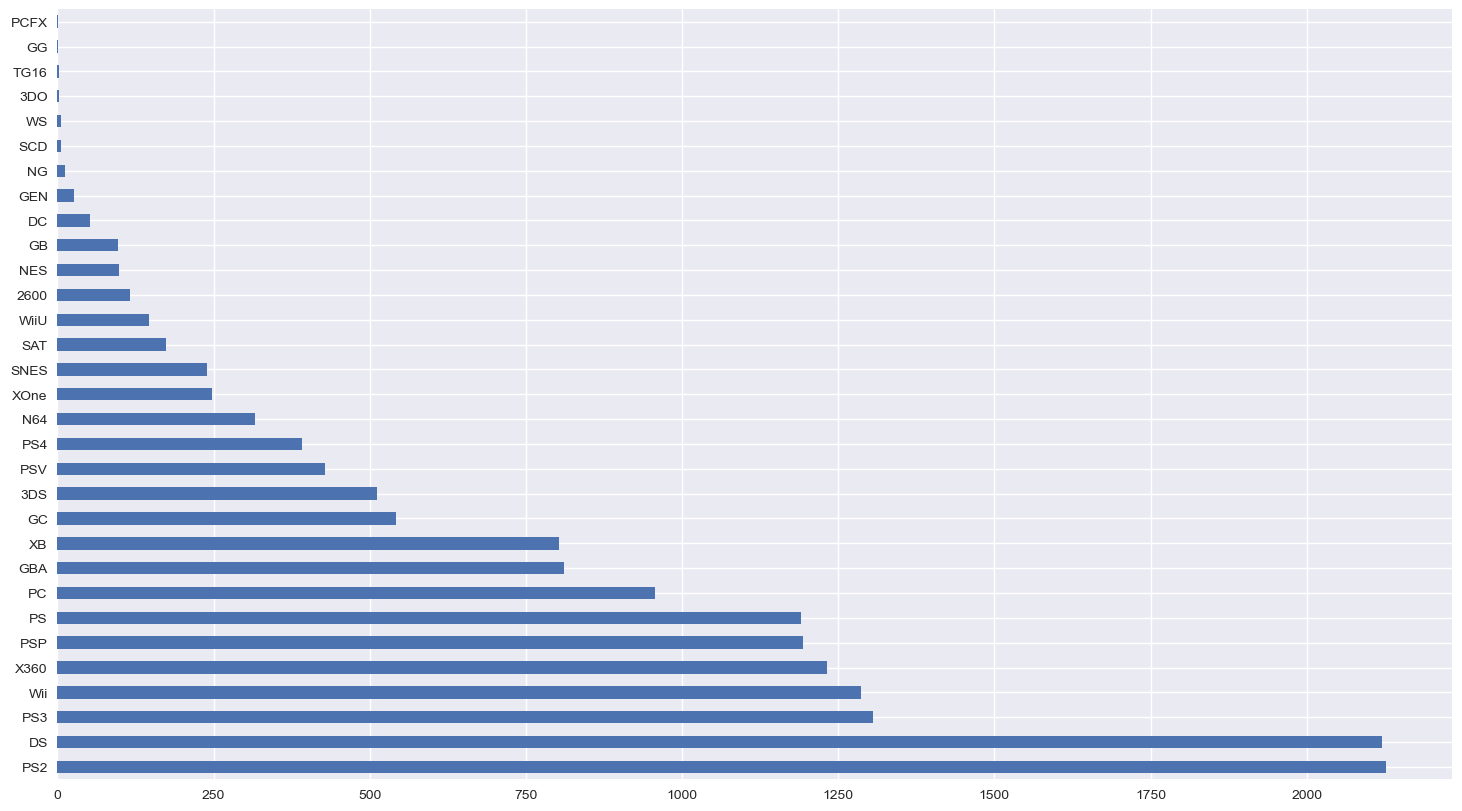

In [31]:
# сколько было выпущено игр на платформу
(
    cleared_data['platform']
    .value_counts()
    .plot(kind='barh', figsize=(18,10))
);

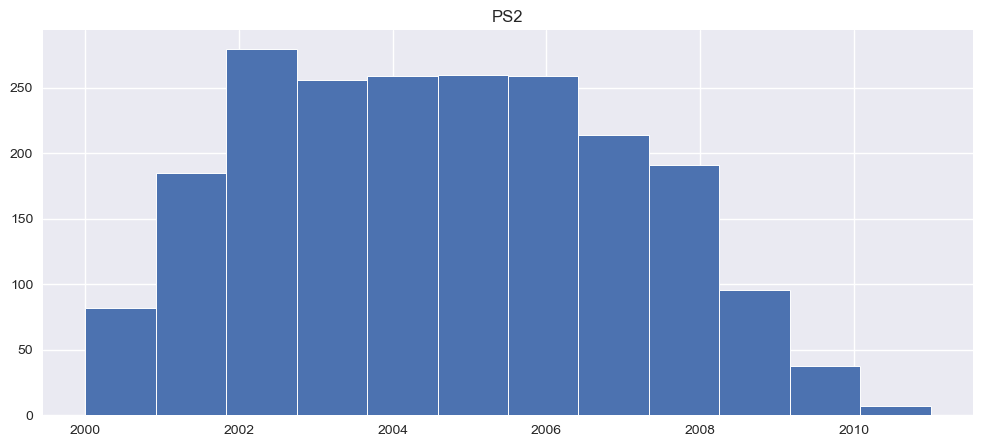

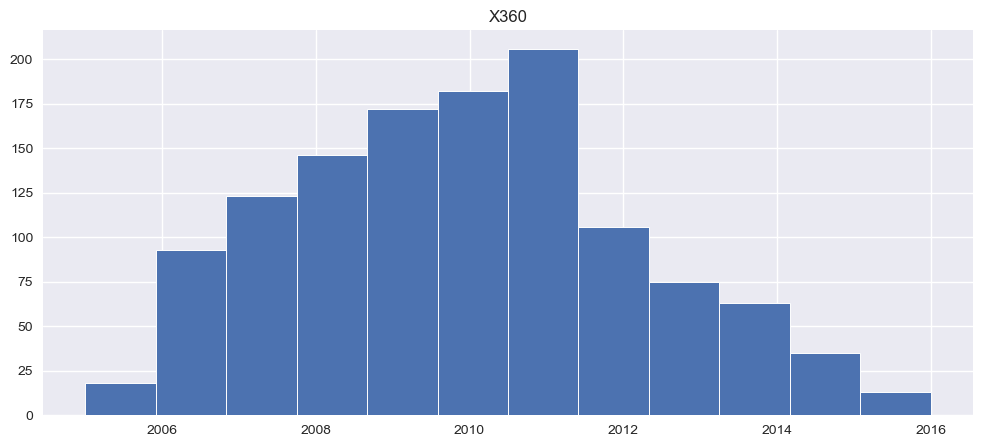

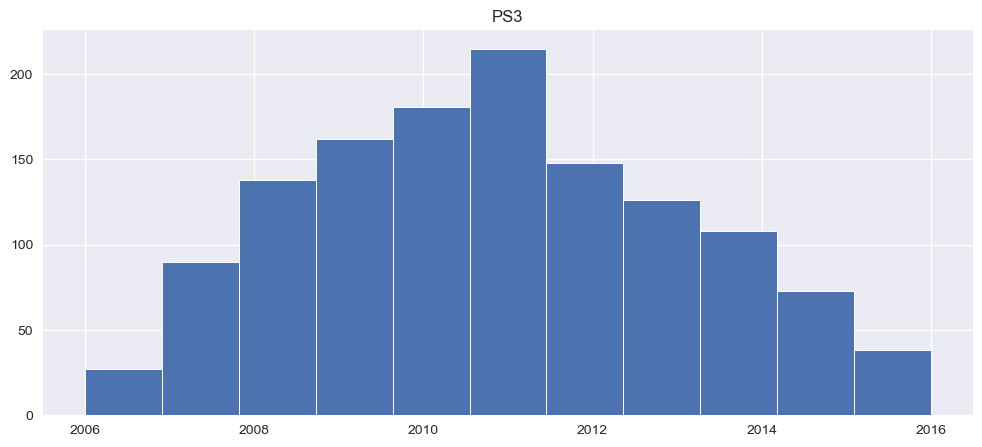

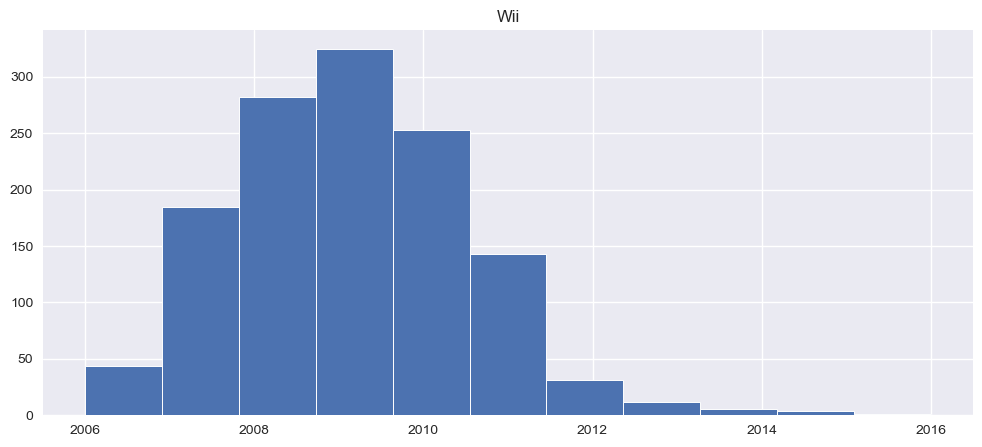

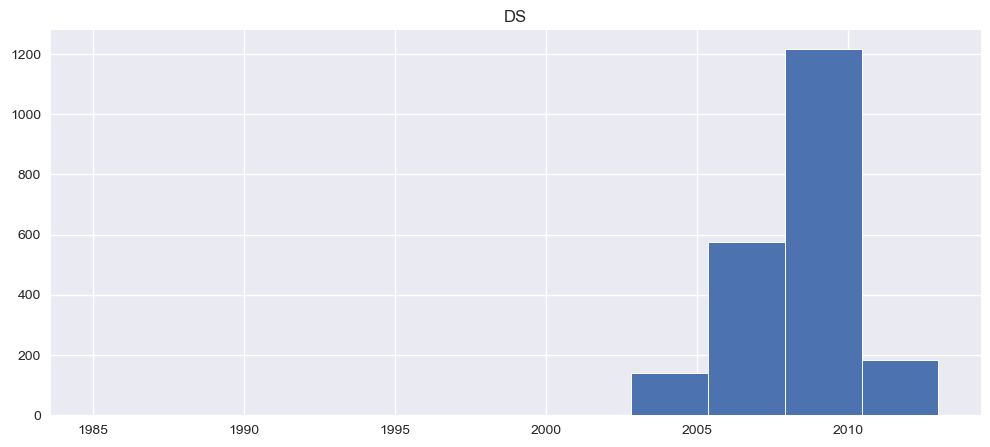

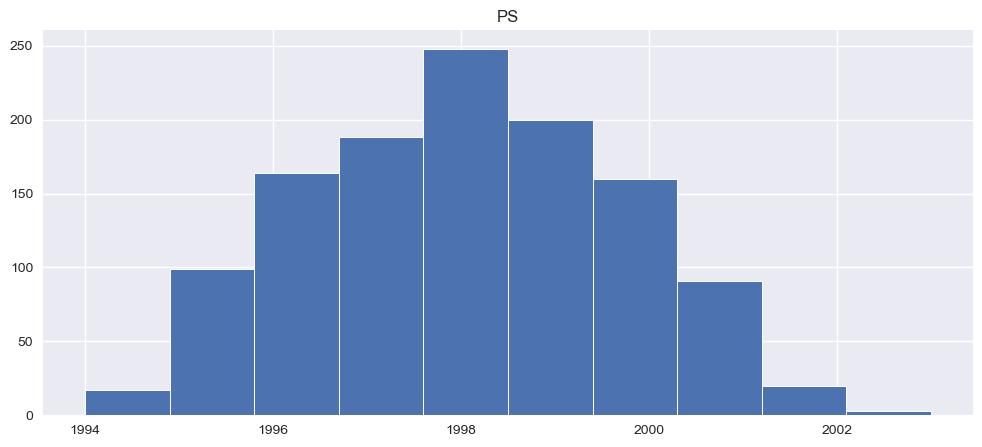

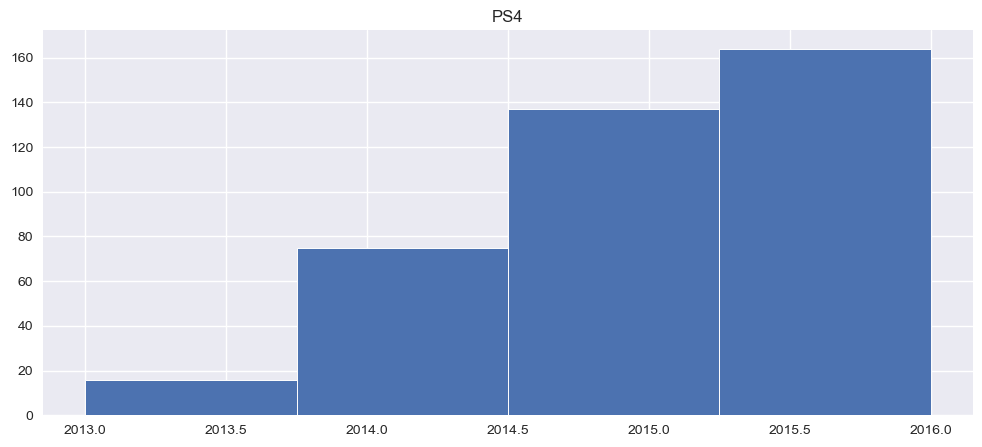

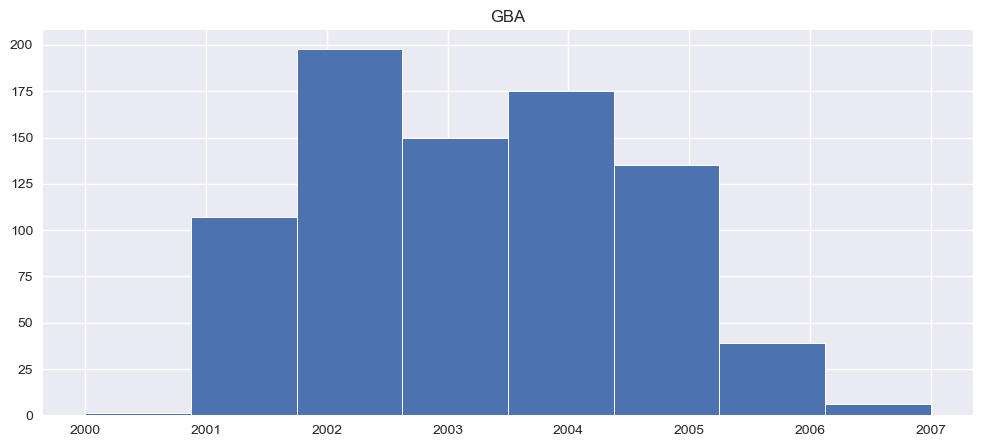

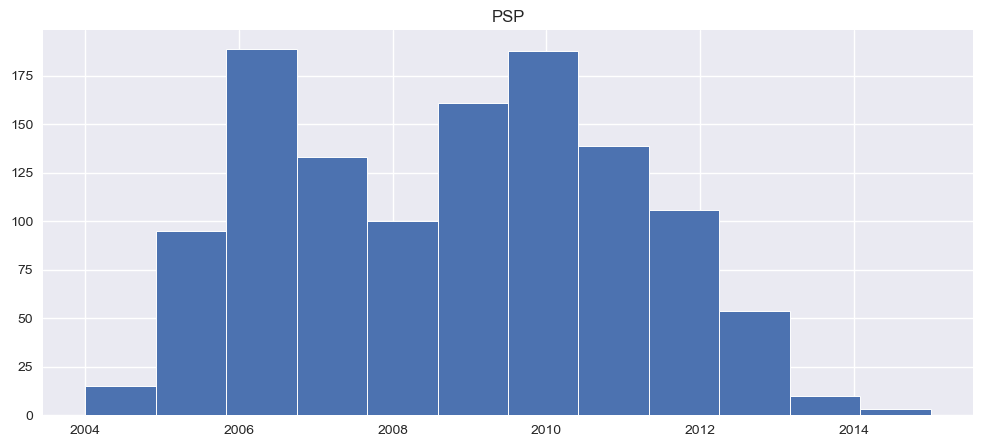

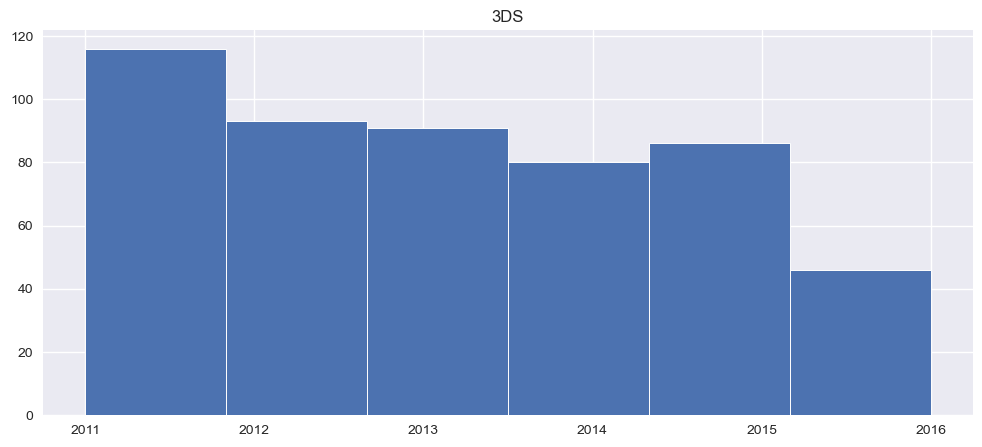

In [32]:
# Топ 10 самых прибыльных платформ и их продажи по годам
for platform in list(cleared_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:10].index):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(platform)
    ax.hist(cleared_data[cleared_data['platform'] == platform]['year_of_release'],
            bins=cleared_data[cleared_data['platform'] == platform]['year_of_release'].unique().shape[0],
            edgecolor="white", linewidth=0.7)
    plt.show()

In [33]:
# Сгруппируем по платформам и запишем, сколько они живут
temp = (cleared_data.loc[:,['year_of_release', 'platform']]
        .drop_duplicates()
        .pivot_table(index=['platform'], values='year_of_release', aggfunc='count')
       )
temp

,year_of_release
platform,
2600,10
3DO,2
3DS,6
DC,7
DS,11
GB,13
GBA,8
GC,7
GEN,5


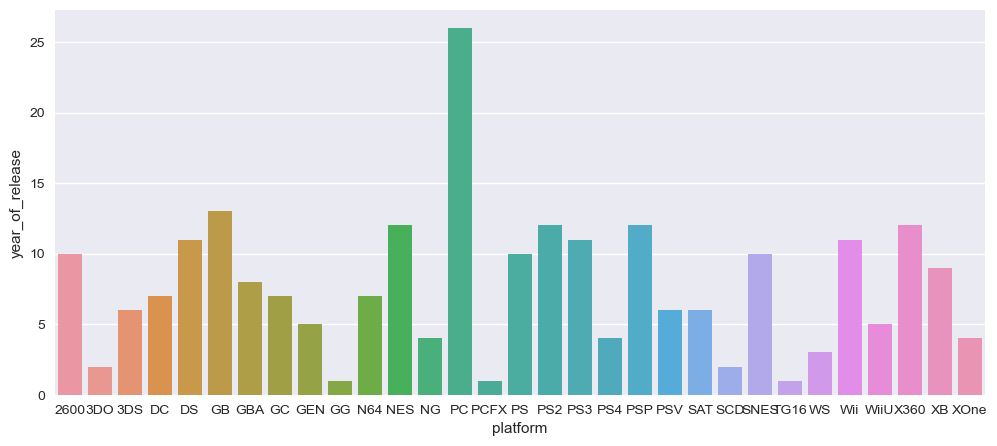

In [34]:
# Сколько же живет каждая платформа по отдельности?
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x=temp.index,
            y='year_of_release',
            data=temp);

In [35]:
# Посмотрим разброс по данным и их среднее
temp.describe()

,year_of_release
count,31.000000
mean,7.677419
std,5.081910
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


Средний срок жизни платформ 7 лет.

### Актуальный период

За актуальный период возьмем половину срока жизни платформы. 

In [36]:
actual_data = cleared_data[cleared_data['year_of_release'] > (2016 - 3)].copy()

Сделаем так, чтобы взять захватить уже умершие платформы.

### Платформы с потенциалом

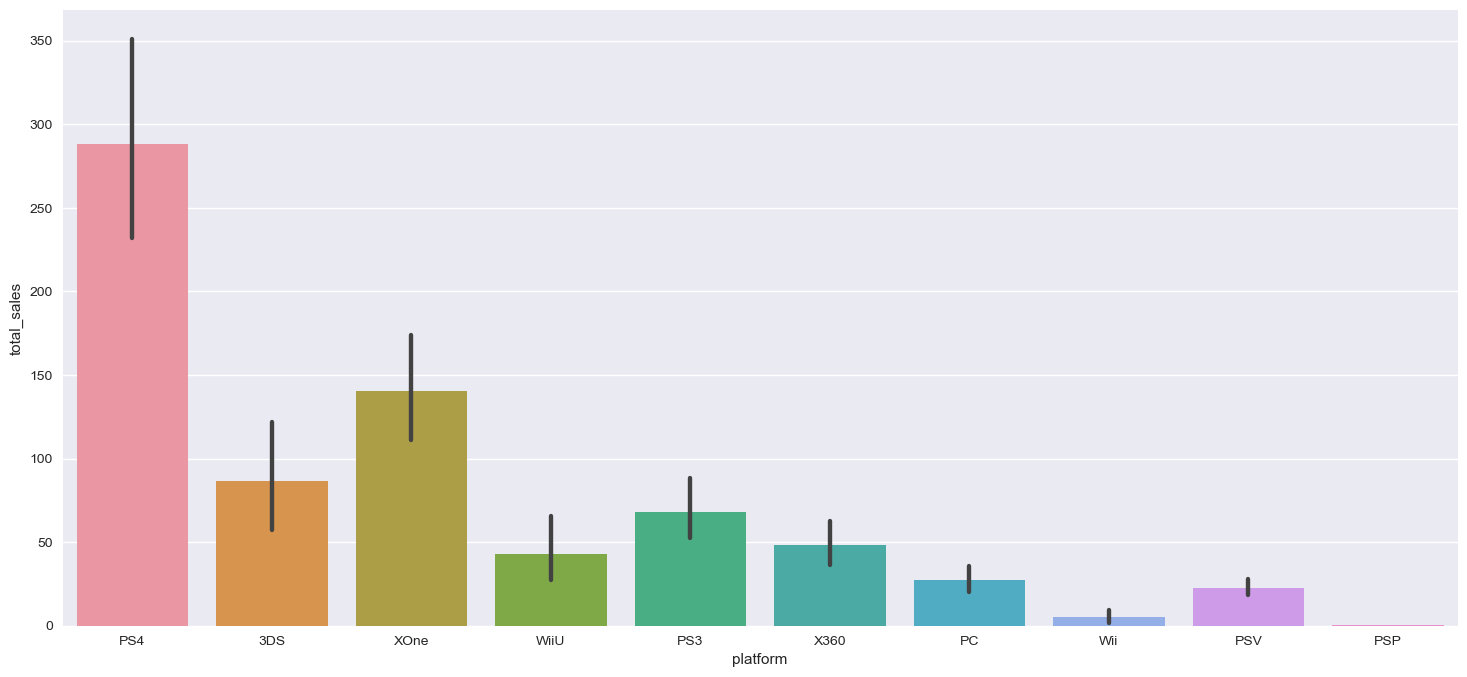

In [37]:
sns.barplot(data=actual_data, x='platform', y='total_sales', estimator=sum);

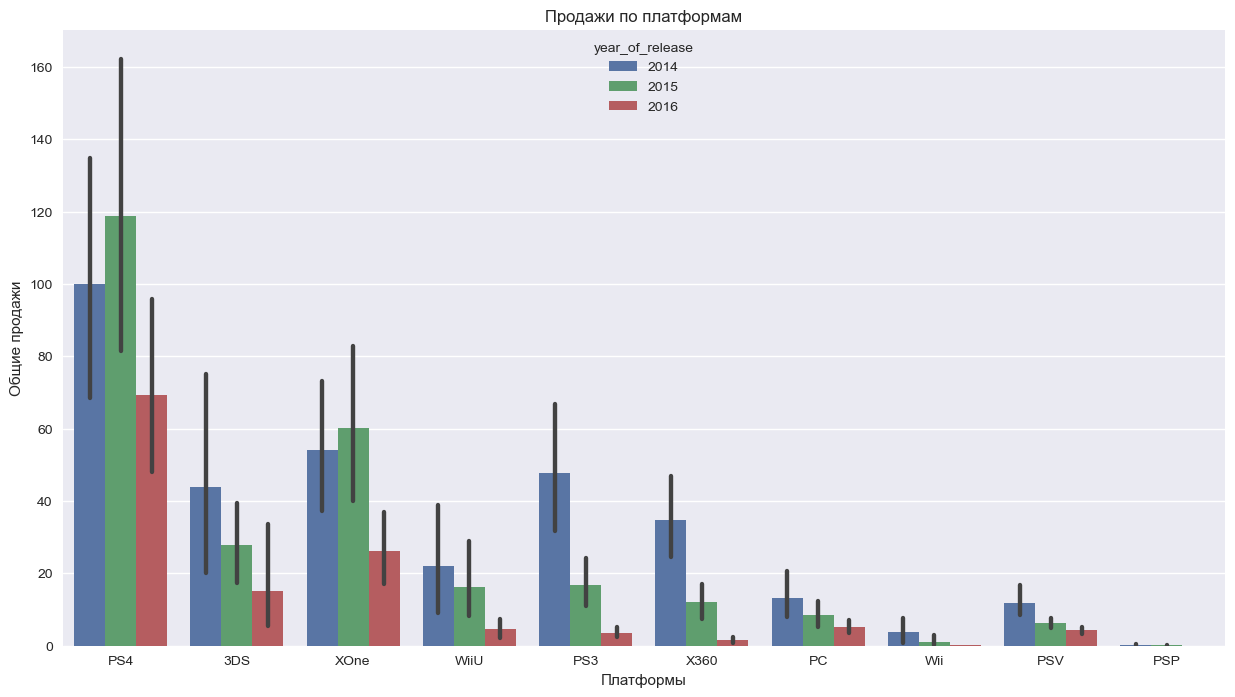

In [38]:
plt.figure(figsize=(15, 8))
(
    sns.barplot(data=actual_data, x='platform',y='total_sales', hue='year_of_release', estimator=sum)
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи')
);

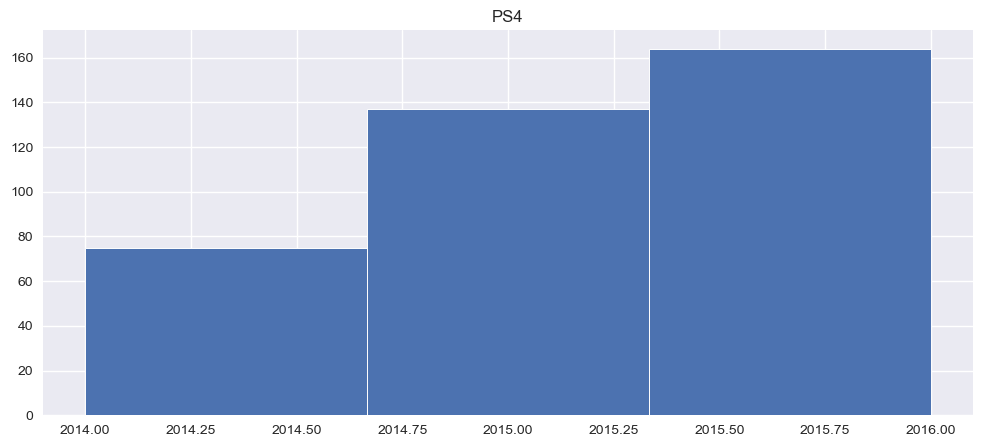

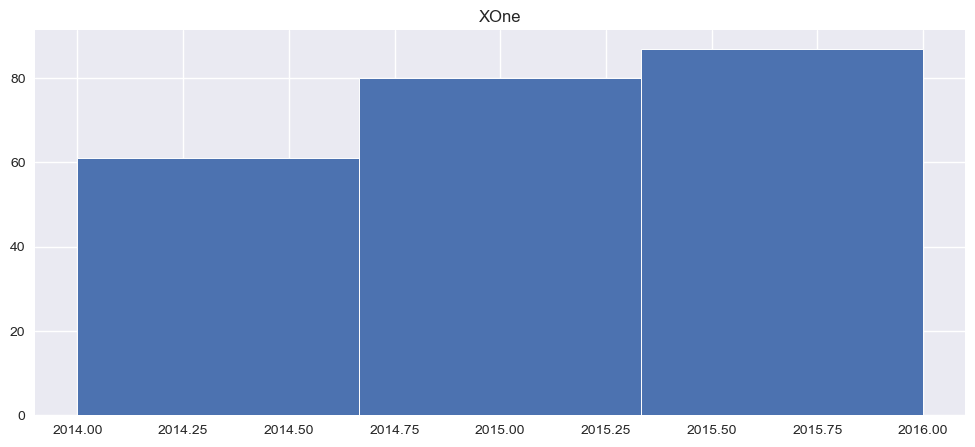

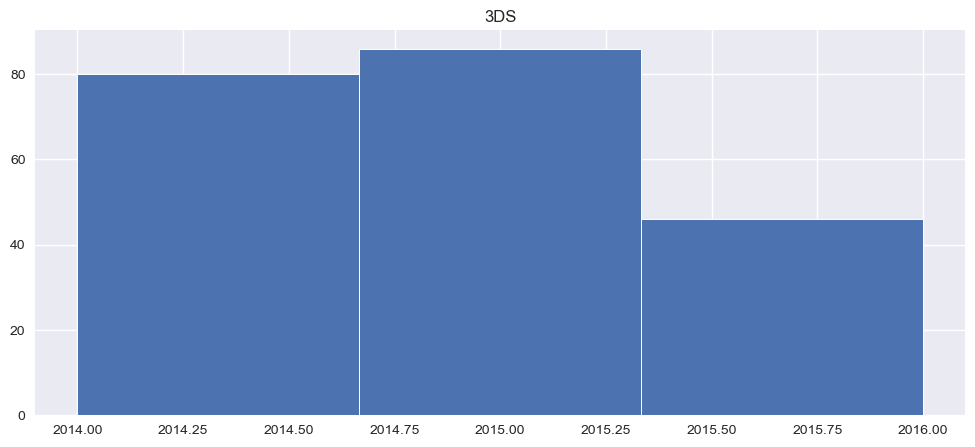

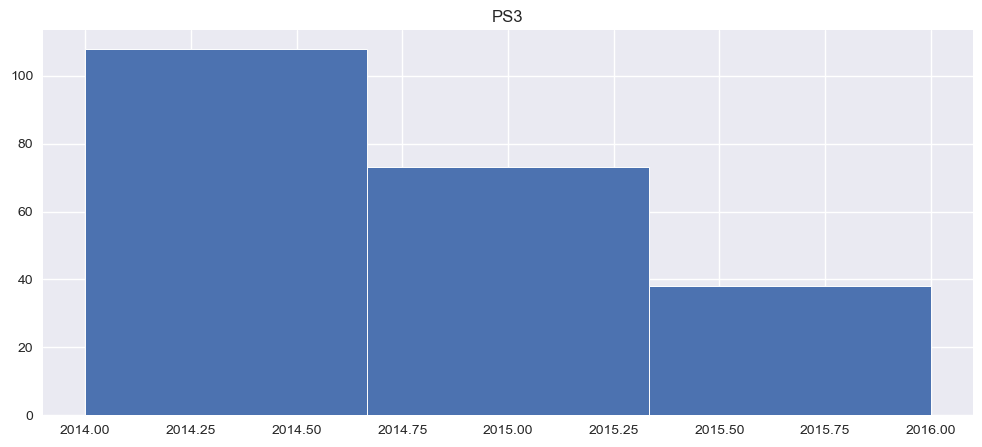

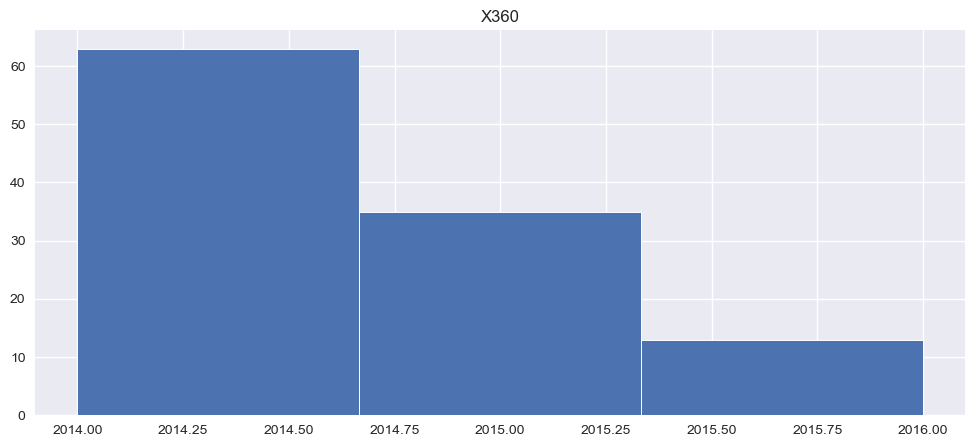

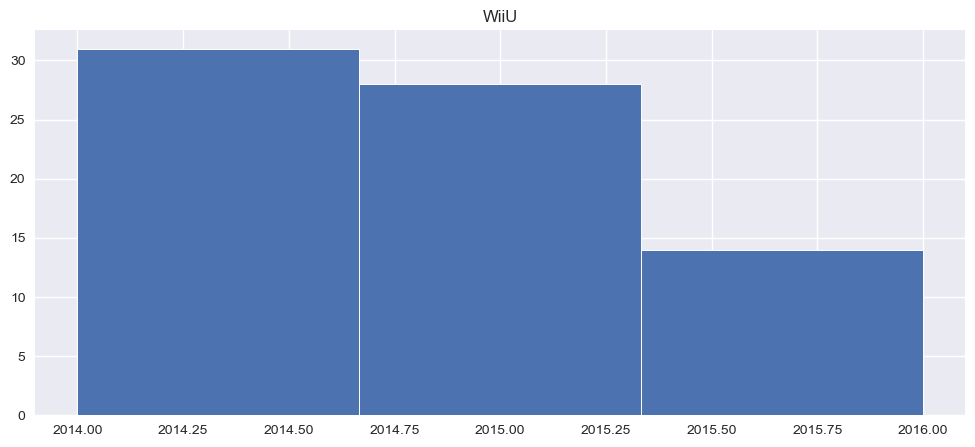

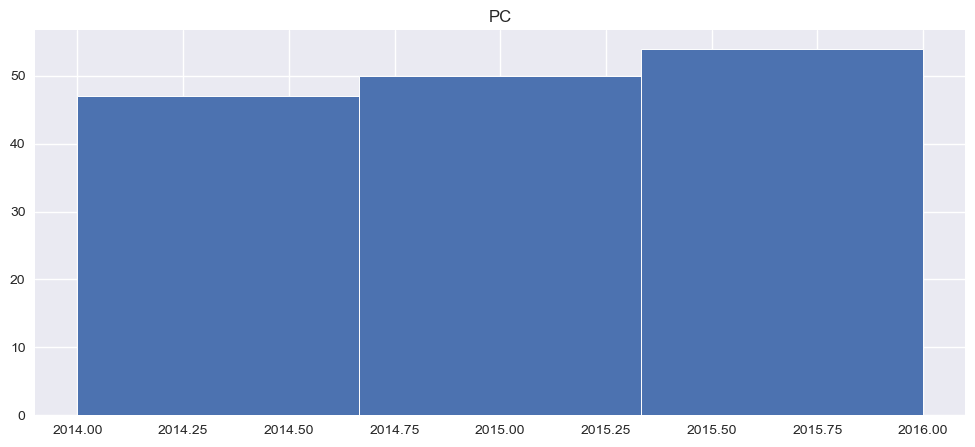

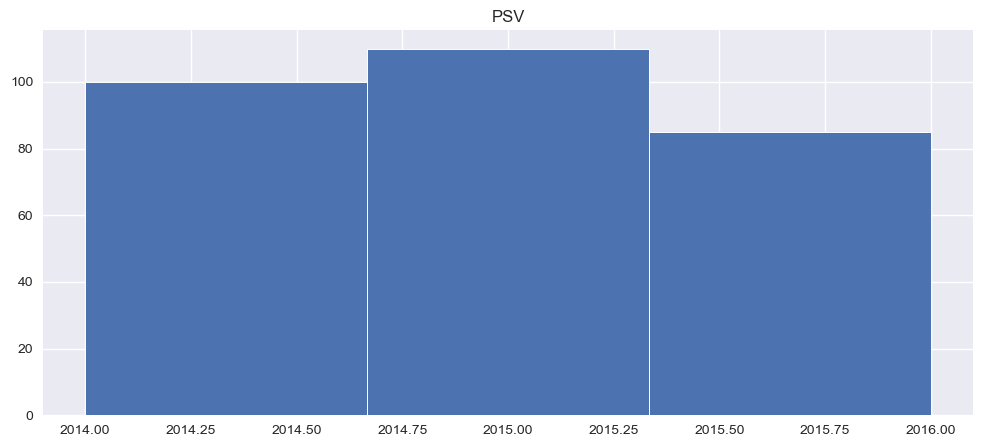

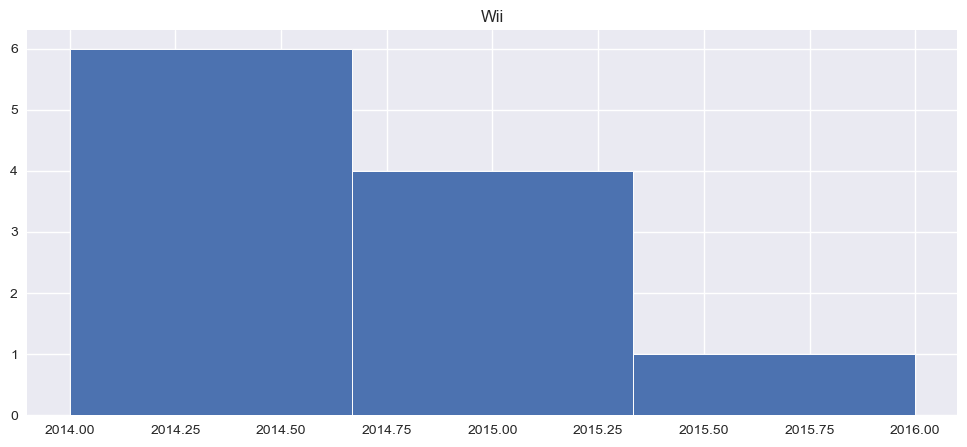

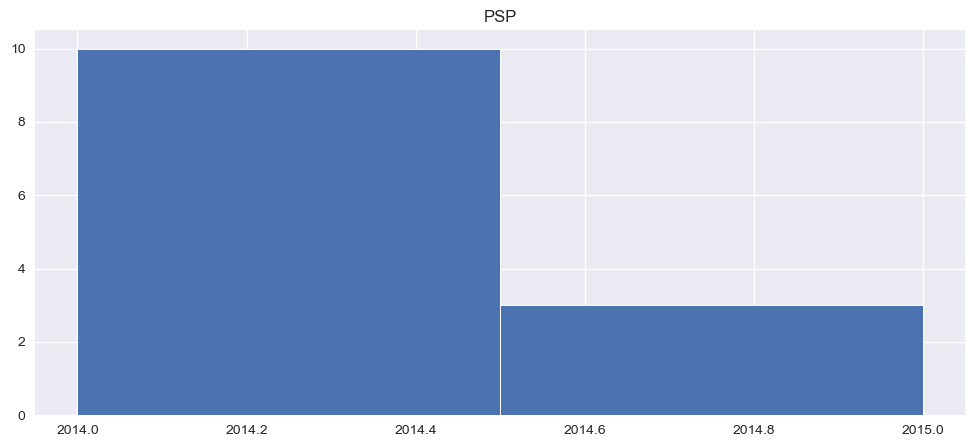

In [39]:
# Топ 10 самых прибыльных платформ с 2013
temp = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:10]

for platform in temp.index:
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(platform)
    ax.hist(actual_data[actual_data['platform'] == platform]['year_of_release'], 
            bins=actual_data[actual_data['platform'] == platform]['year_of_release'].unique().shape[0]
            , edgecolor="white", linewidth=0.7)
    plt.show()

Самыми перспективными можно считать PS4, XOne. У них ярко выражено увелечение объема продаж, вероятно из-за того, что это следующее поколение самых прибыльных платформ. 

По продажам лидируют X360, PS3, Wii. Это платформы, которые отжили свой полный цикл, потому продажи у них падают.

### Ящик с усами

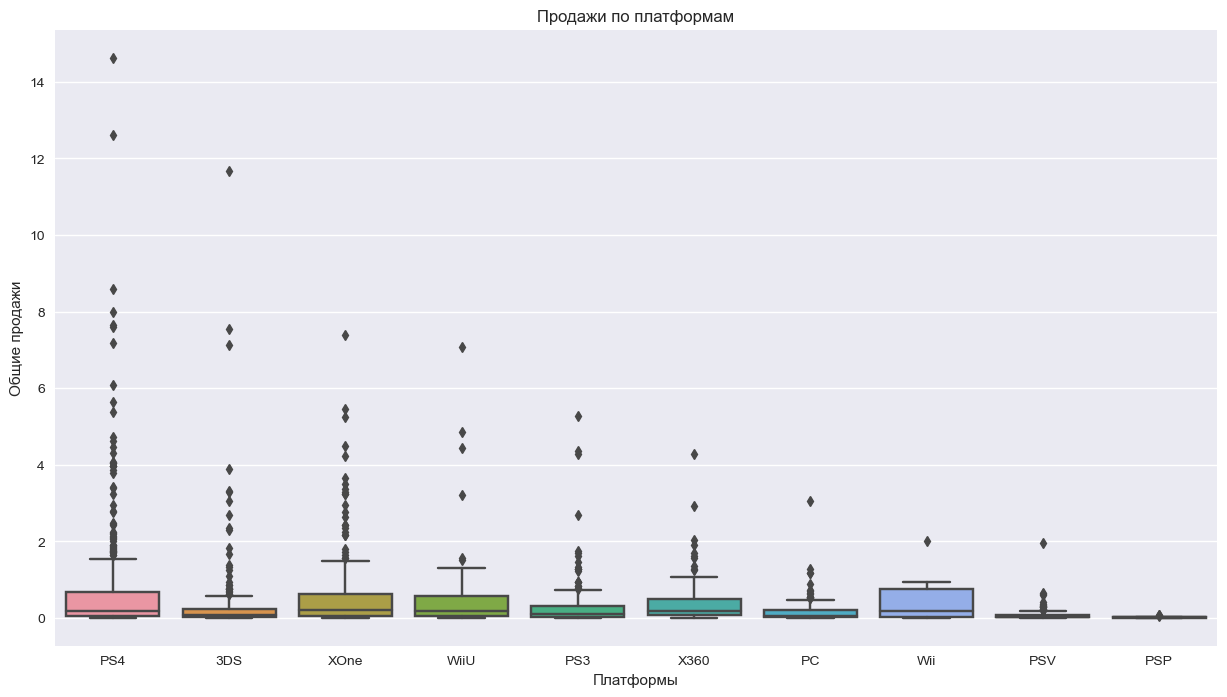

In [40]:
plt.figure(figsize=(15, 8))
temp = actual_data

(
    sns.boxplot(data = temp, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи')
    
)

plt.show()

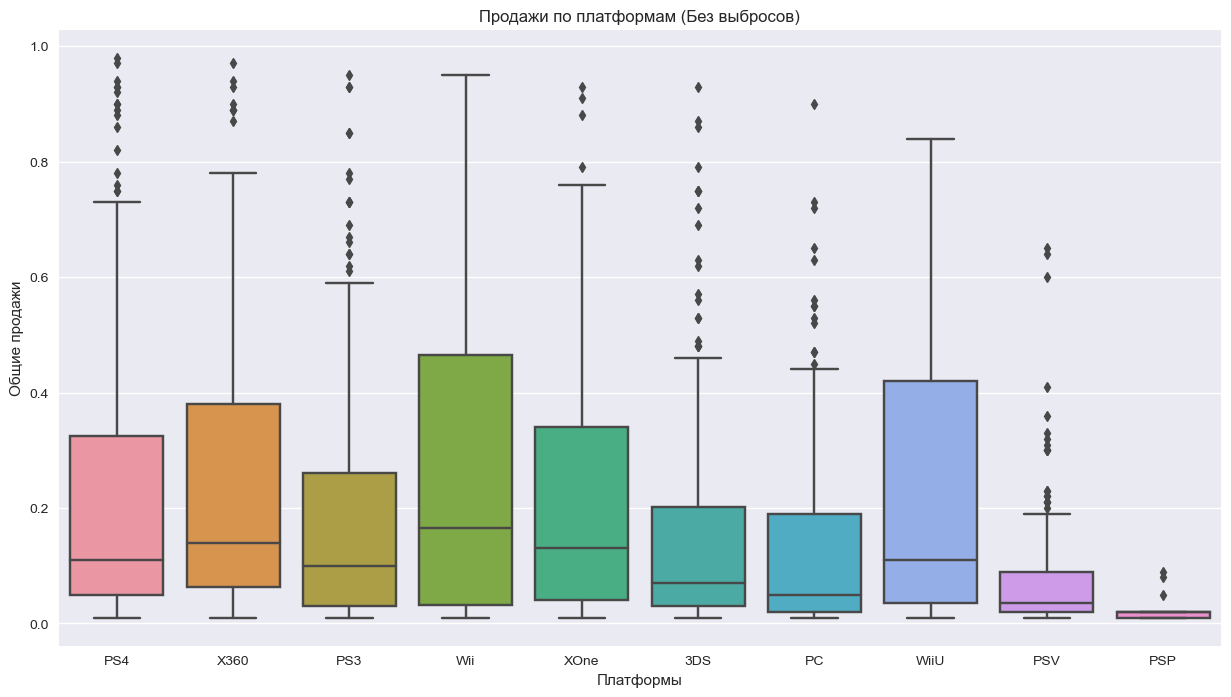

In [41]:
plt.figure(figsize=(15, 8))
temp = actual_data.loc[actual_data['total_sales'] < 1]

(
    sns.boxplot(data = temp, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам (Без выбросов)', xlabel = 'Платформы', ylabel = 'Общие продажи')
    
)

plt.show()

На многих платформах присутствуют выбросы. Похоже это бестселлеры на своих платформах. Они очень выбиваются из массы других игр.

### Корреляция отзывов и продаж

In [42]:
# Выберем популярную платформу, по которой и посмотрим корреляцию
popular_platform = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[0]

In [43]:
popular_platform

'PS4'

In [44]:
actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['critic_score'].isna())]['total_sales'].describe()

count    245.000000
mean       0.898245
std        1.631303
min        0.010000
25%        0.070000
50%        0.240000
75%        0.900000
max       12.620000
Name: total_sales, dtype: float64

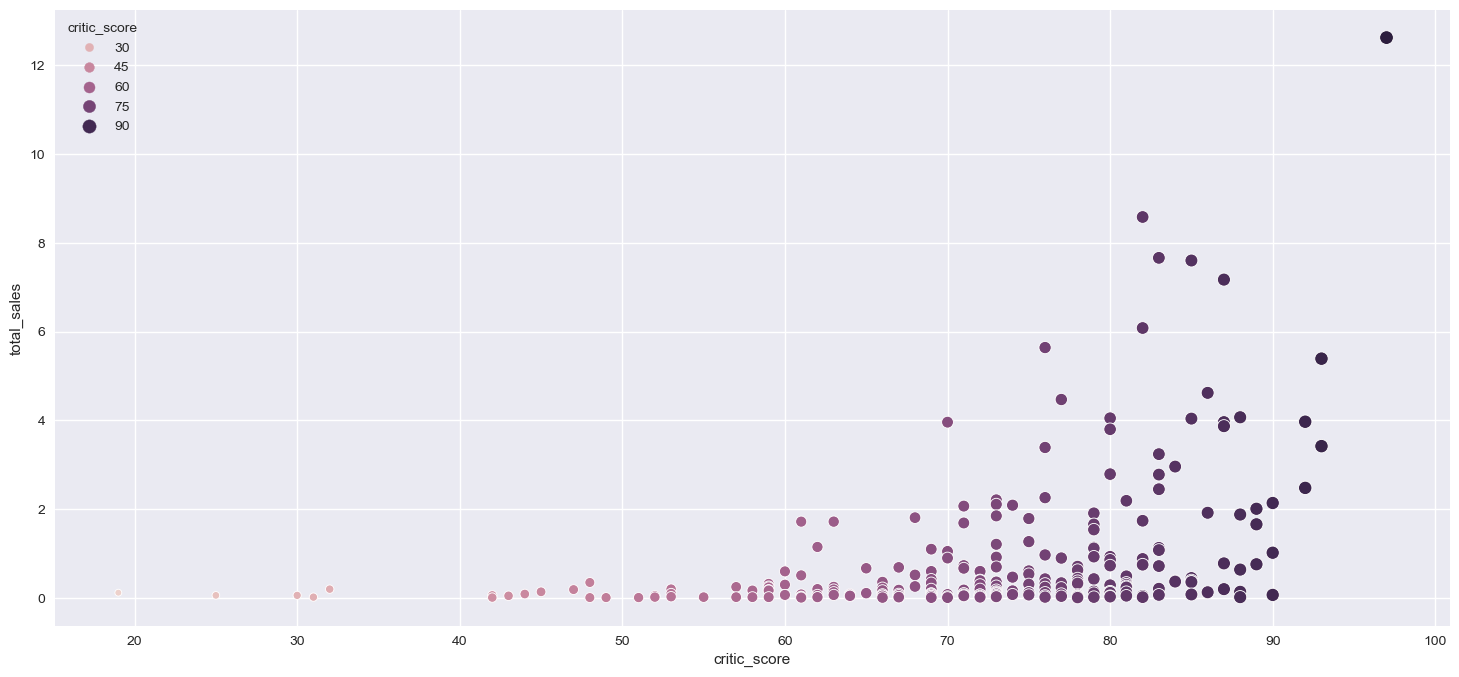

In [45]:
temp = actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['critic_score'].isna())].copy()
temp['critic_score'] = temp['critic_score'].astype('float')

(
    sns.scatterplot(data=temp, x='critic_score', y='total_sales', hue='critic_score', size='critic_score')
);

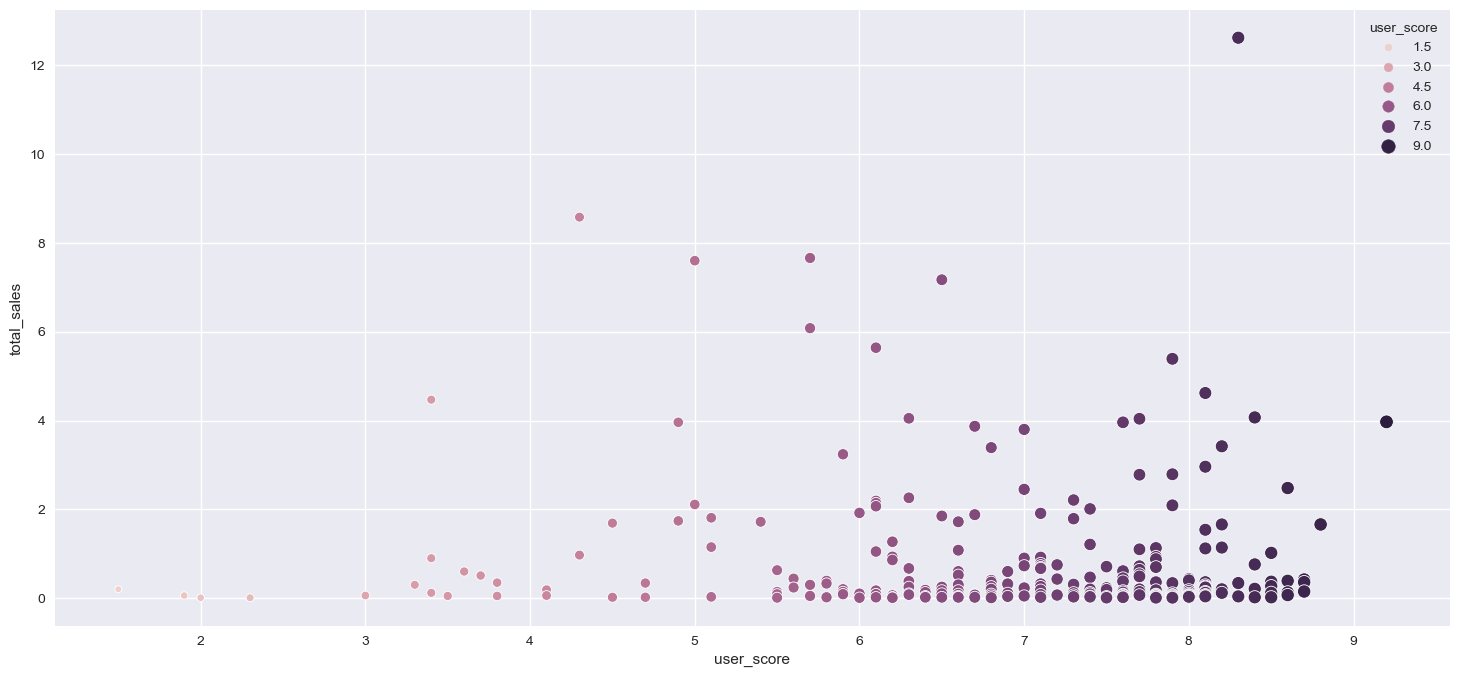

In [46]:
temp = actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['user_score'].isna())]

(
    sns.scatterplot(data=temp, x='user_score', y='total_sales', size='user_score', hue='user_score')
);

Не похоже, что есть прямая зависимость между отзывами и продажами на одной из популярных платформ. 

In [47]:
actual_data[actual_data['platform'] == popular_platform]['total_sales'].astype(float).corr(
    actual_data[actual_data['platform'] == popular_platform]['user_score'].astype(float)
)

-0.04029170978314621

Зависимость с оценками пользователей слабая отрицательная.

In [48]:
actual_data[actual_data['platform'] == popular_platform]['total_sales'].astype(float).corr(
    actual_data[actual_data['platform'] == popular_platform]['critic_score'].astype(float)
)

0.3963095483373526

Зависимость с оценками критиков умеренная положительная.

In [49]:
# Это просто функция, чтобы добавить столбец со средней оценкой
def func(row):
    try:
        if row['critic_score'] == np.nan:
            return row['user_score']
        elif row['user_score'] == np.nan:
            return row['critic_score']
        return (row['user_score'] * 10 + row['critic_score']) // 2
    except:
        return row['user_score'] * 10 + row['critic_score']

# Эта функция выведет 4 графика по выбранной платформе за 2016abs год
def temp_func(platformi):
    cleared_data['mean_score'] = cleared_data.apply(func,axis=1)
    cleared_data['mean_score'] = pd.to_numeric(cleared_data['mean_score'], errors='coerce')
    cleared_data['year_of_release'] = cleared_data['year_of_release'].astype('int')
    
    temp = cleared_data.query('year_of_release == 2016\
                                and platform ==@platformi').reset_index(drop=True)
    temp['critic_score'] = temp['critic_score'].astype('float')
    
    fig, axis = plt.subplots(2,2, figsize=(18,10))
    # График корреляций всего от всего
    sns.heatmap(temp.loc[:,['total_sales', 'mean_score', 'user_score', 'critic_score']].corr(),annot=True,ax=axis[0,0]);      
    # График продаж от средней оценки 
    sns.scatterplot(x='mean_score',y='total_sales',hue='mean_score',size='mean_score',sizes=(20,200),data=temp,ax=axis[0,1]);
    # График продаж от пользовательской оценки
    sns.scatterplot(x='user_score',y='total_sales',hue='user_score', size='user_score',sizes=(20,200), data=temp,ax=axis[1,0]);
    # График продаж от оценок критиков
    sns.scatterplot(x='critic_score',y='total_sales',hue='critic_score', size='critic_score',sizes=(20,200), data=temp,ax=axis[1,1]);

Выберем несколько самых интересных (потенциально прибыльных) платформ и выведем для них графики

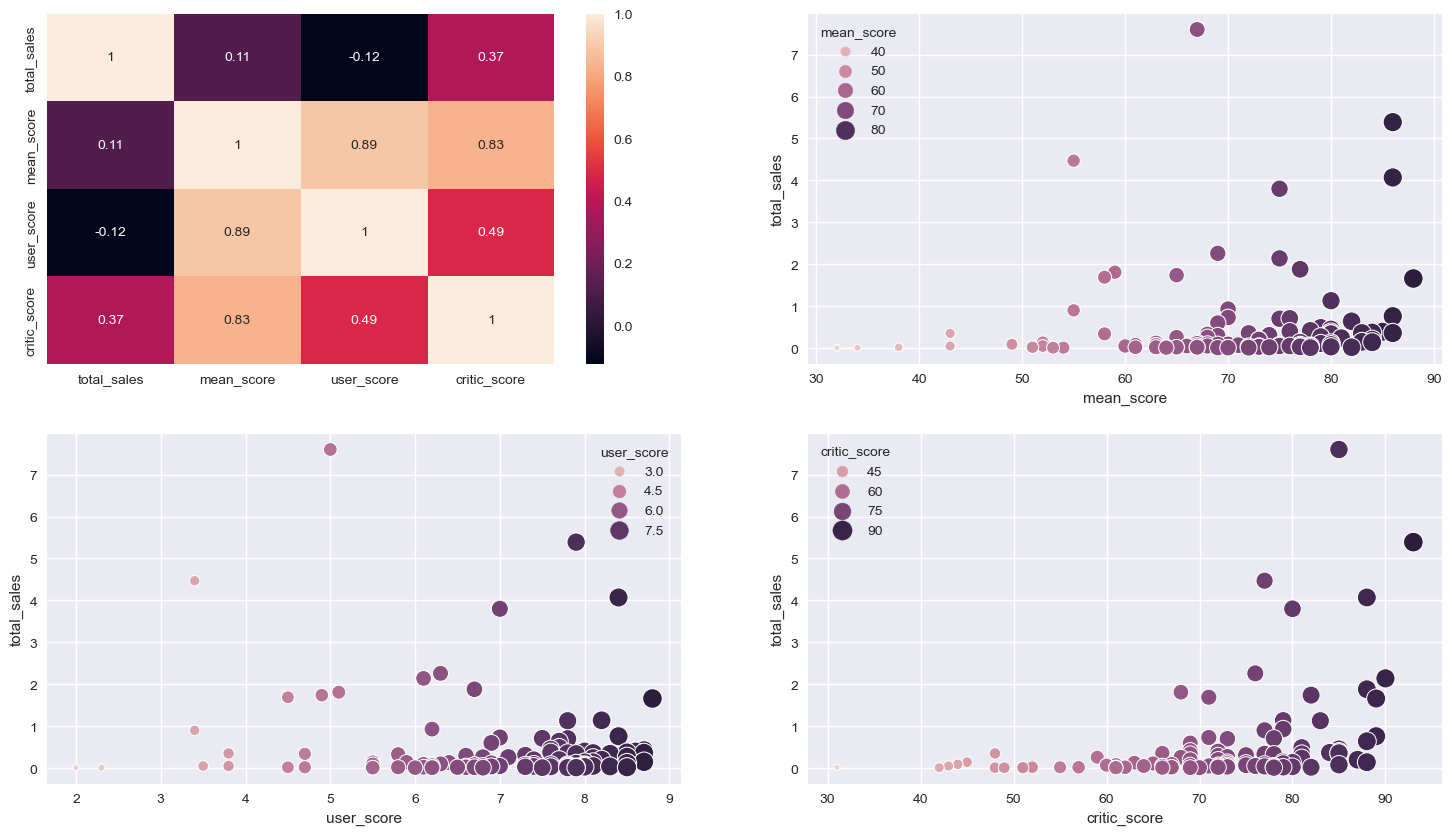

In [50]:
temp_func('PS4')

PS4: Зависимость с пользовательскими отзывами слабая, обратная. Зависимость с отзывами критиков умеренная положительная.

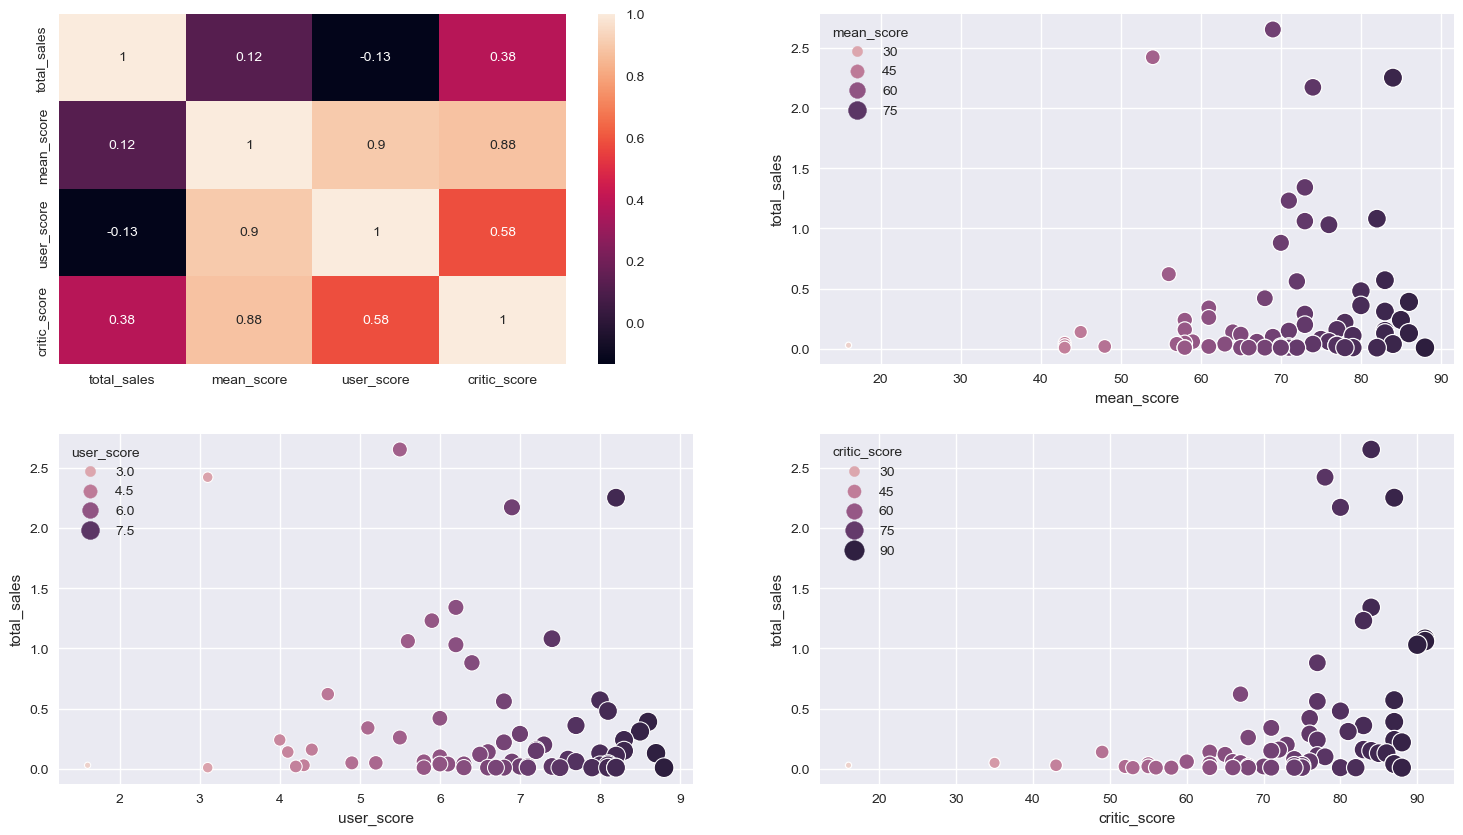

In [51]:
temp_func('XOne')

XOne: Зависимость с пользовательскими отзывами слабая, обратная. Зависимость с отзывами критиков умеренная положительная.

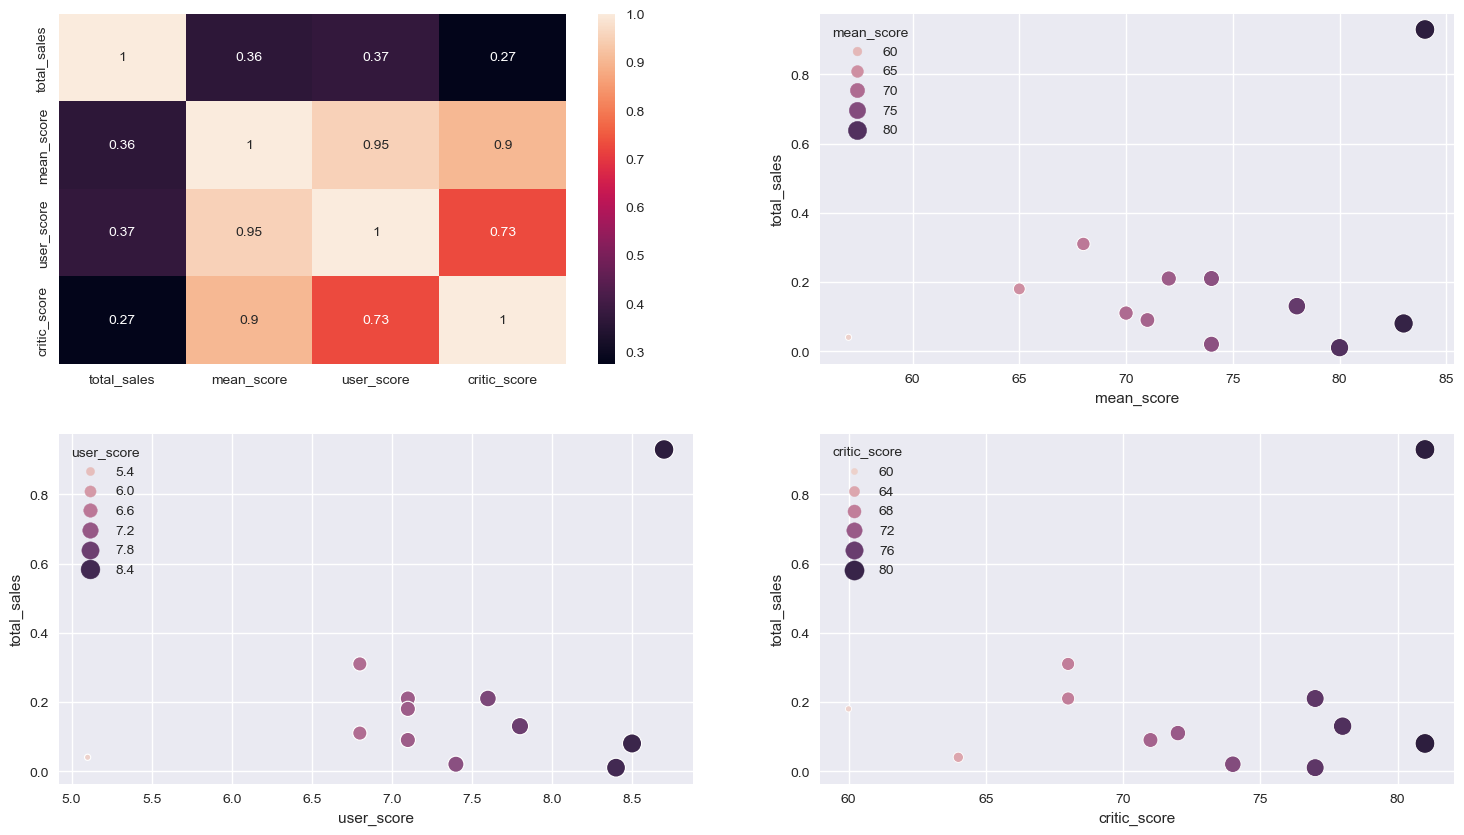

In [52]:
temp_func('3DS')

3DS: Зависимость с пользовательскими отзывами умеренная положительная. Зависимость с отзывами критиков умеренная положительная.

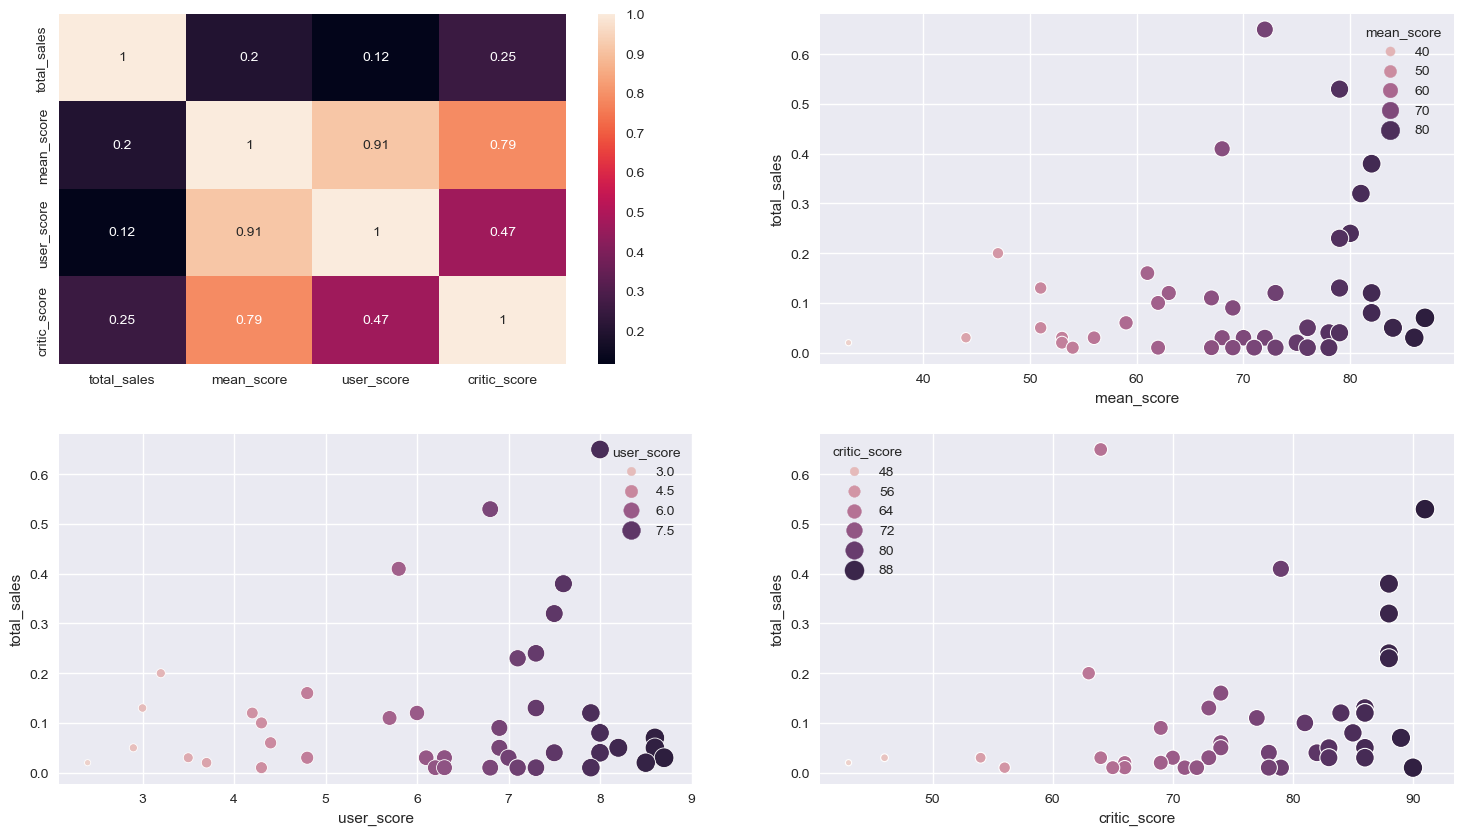

In [53]:
temp_func('PC')

PC: Зависимость с пользовательскими отзывами слабая положительная. Зависимость с отзывами критиков слабая положительная.

Так как PC это исключительная платформа, я не буду ее брать в среднее.

**Промежуточный итог**: 

С 1994-го года популярность игр все растет. За это время было много платформ для них, но в основном они все живут около 10 лет. 


Пользовательские отзывы очень слабо коррелируют с продажами и часто даже отрицательно. Отзывы критиков же средне коррелируют с продажами (0.29 - 0.39). Значит критики лучше прогнозируют успех игры, по сравнению с пользователями.

### Распределение продаж по жанрам

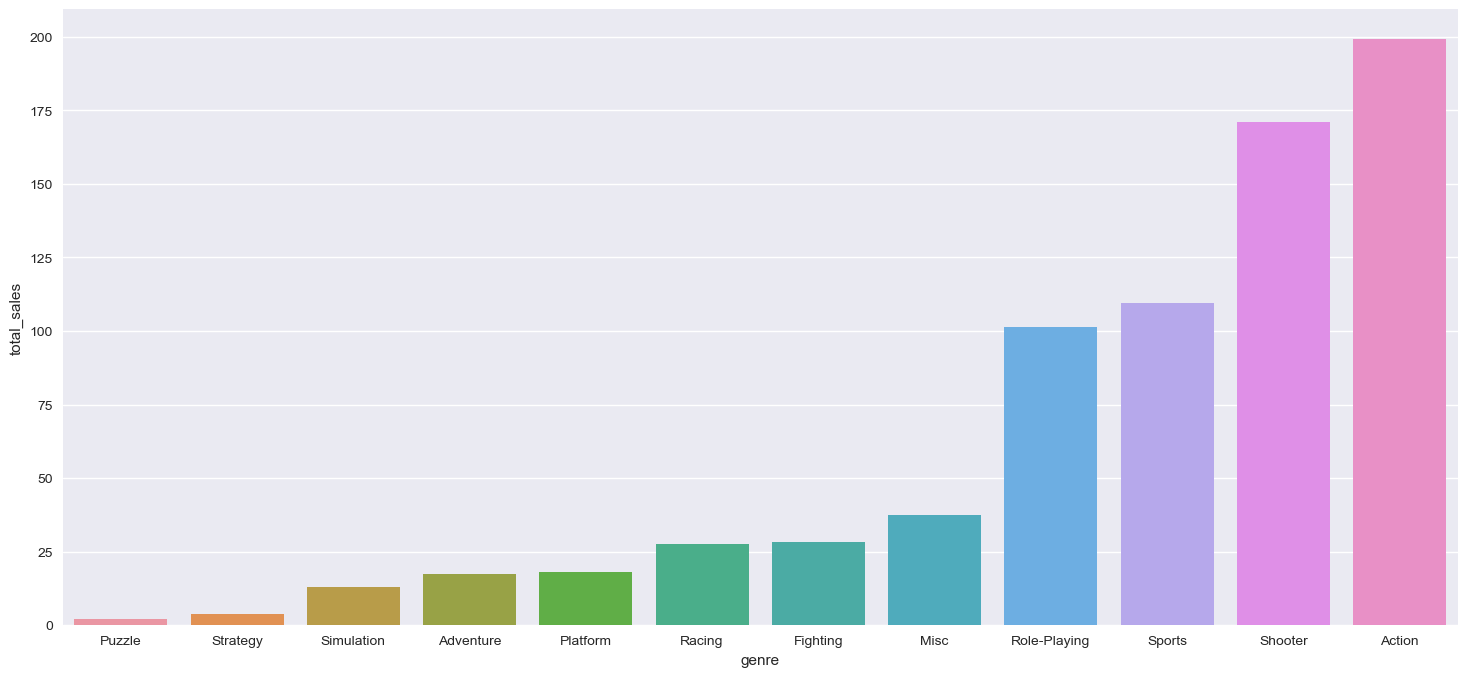

In [54]:
# Рассмотрим суммарные продажи
temp = actual_data.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values('total_sales')

sns.barplot(
    data=temp, 
    x=temp.index, y='total_sales',
    order=temp.index,
);

Экшен - самый прибыльный жанр игр. Стратегия - наименее прибыльный из всех жанров.

Три самых прибыльных жанра являются активными. При том экшен довольно сильно опережает спорт.

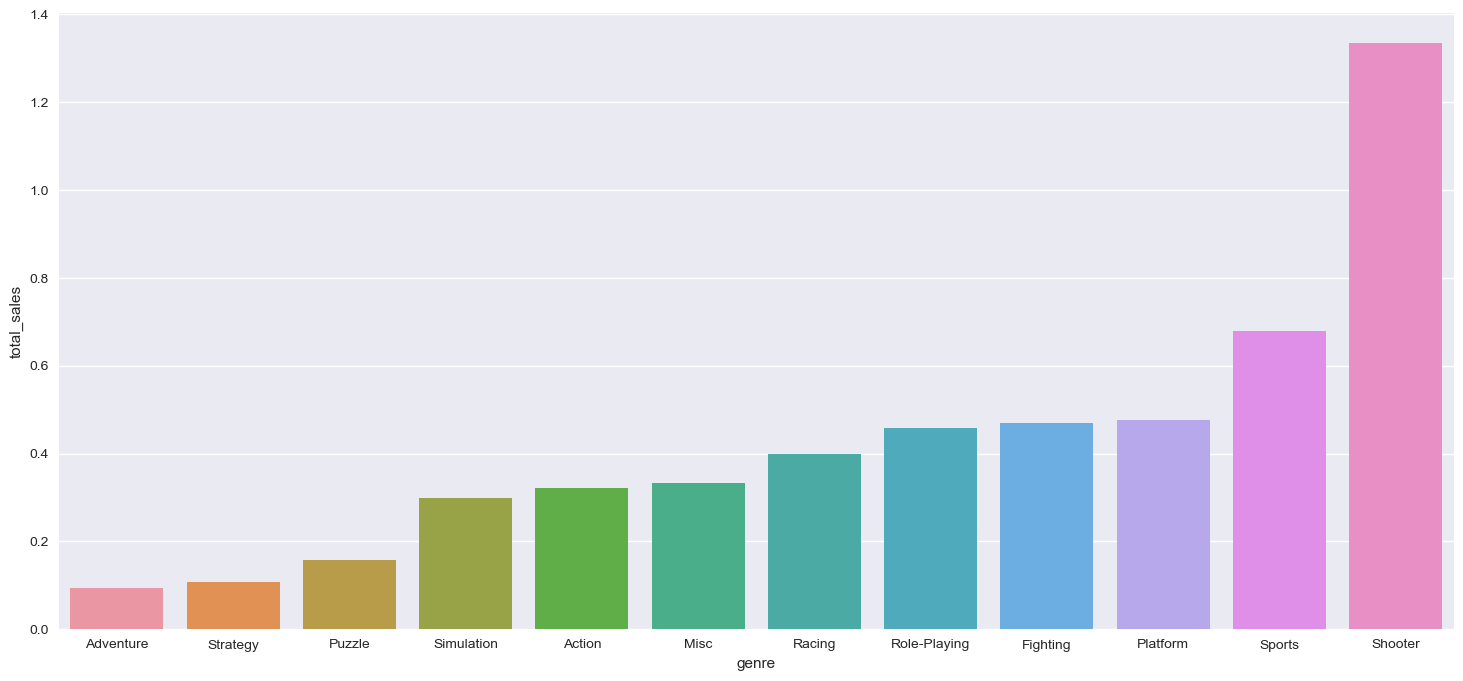

In [55]:
# Рассмотрим медианы продаж
temp = actual_data.pivot_table(index='genre', values='total_sales', aggfunc='mean').sort_values('total_sales')

sns.barplot(
    data=temp, 
    x=temp.index, y='total_sales',
    order=temp.index
);

Данных недостаточно с этих двух графиков, посмотрим еще и выбросы в данных, чтобы определить точно.

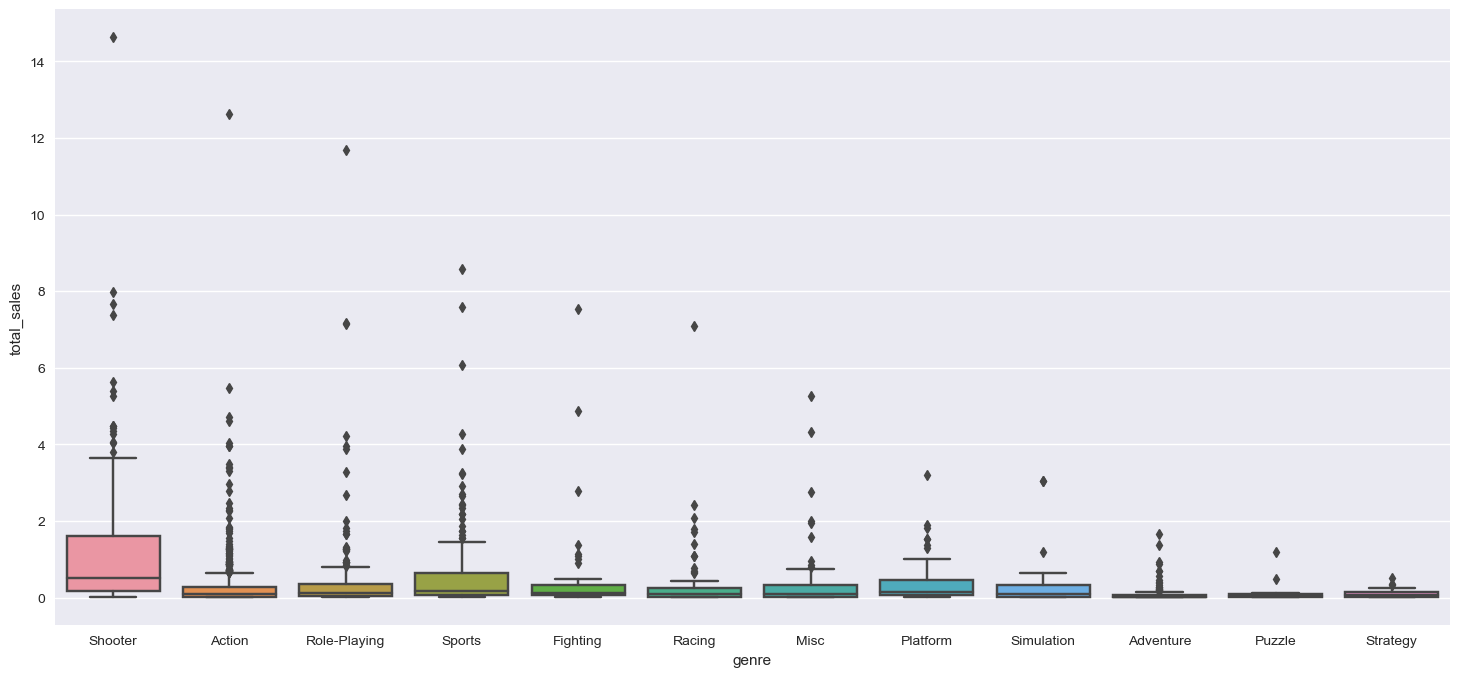

In [56]:
sns.boxplot(
    data=actual_data,
    x='genre',
    y='total_sales'
);

Координальное изменение. Похоже в Action есть несколько очень прибыльных игр, которые и делают суммарную прибыль столь высокой. Однако по медине шутеры обгоняют всех, при том в два или более раза. 

Вероятно стоит в смотреть в первую очередь на нишевые шутеры или даже на спортивные игры, нежели на экшен игры, т.к. в последних получают большую прибыль лишь единицы.

## Регионы

### Платформы в регионах

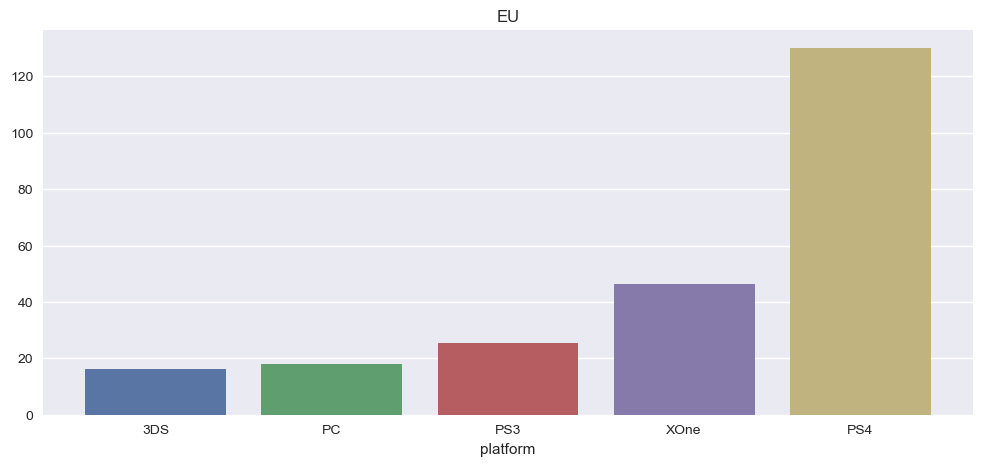

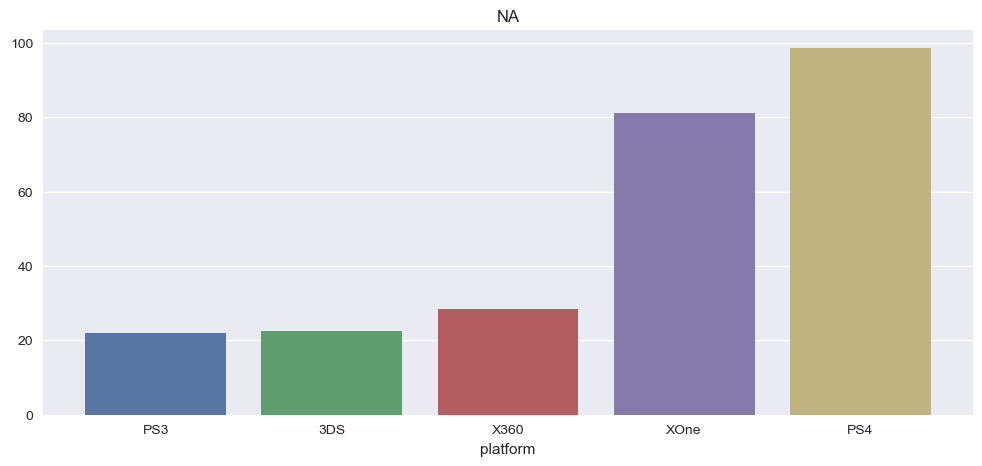

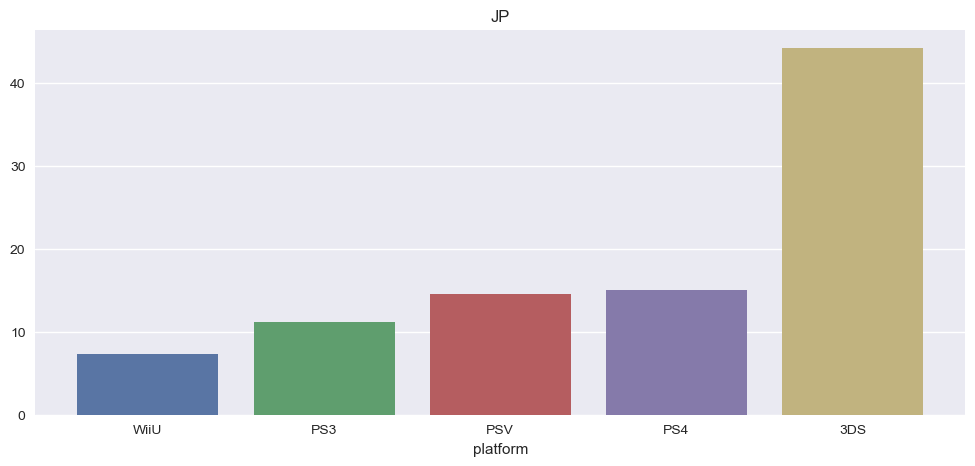

In [57]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))
    # Отсортируем массивы по продажам
    temp = actual_data.groupby('platform')[region].sum().sort_values()[-5:]
    
    sns.barplot(
        x=temp.index, y=temp.values,
        order=temp.index
    );
    
    plt.title(region[:2].upper())
    
    ax.plot();

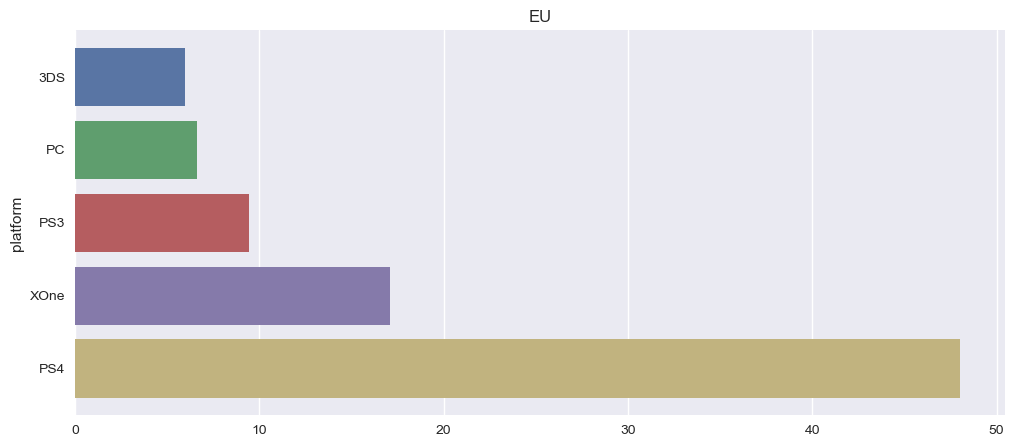

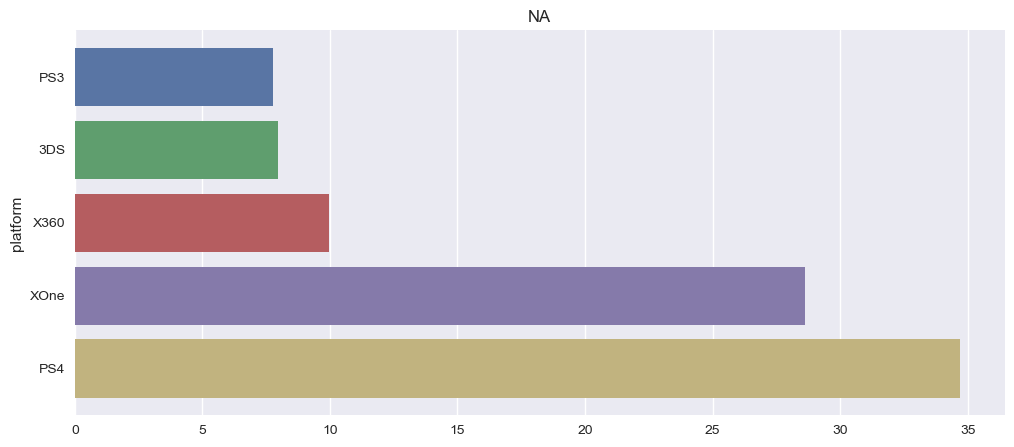

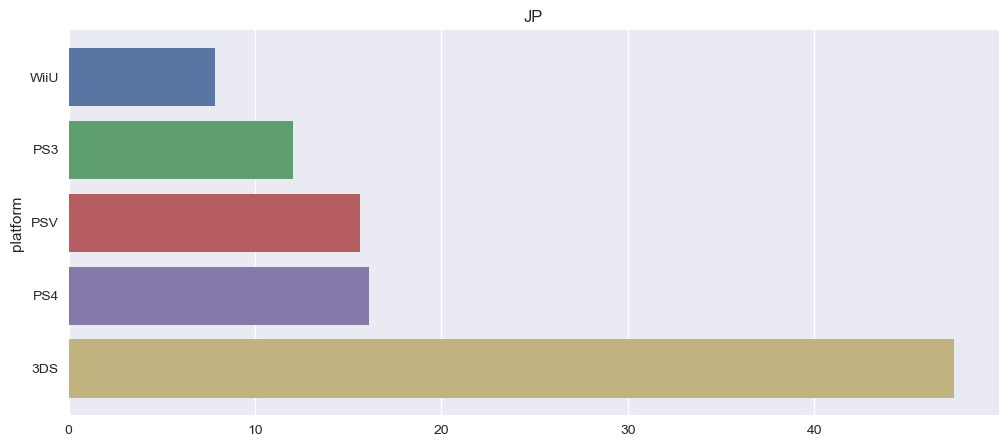

In [58]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))
    # А здесь возьмем долю рынка каждой платформы по региону
    temp = actual_data.groupby('platform')[region].sum().sort_values()[-5:] / actual_data[region].sum() * 100
    
    sns.barplot(
        x=temp.values, y=temp.index,
        order=temp.index
    );
    
    plt.title(region[:2].upper())
    
    ax.plot();

В каждом регионе лидирует своя платформа, но если в японии есть однозначный лидер, то в остальных регионах различия не слишком большие.

### Жанры в регионах

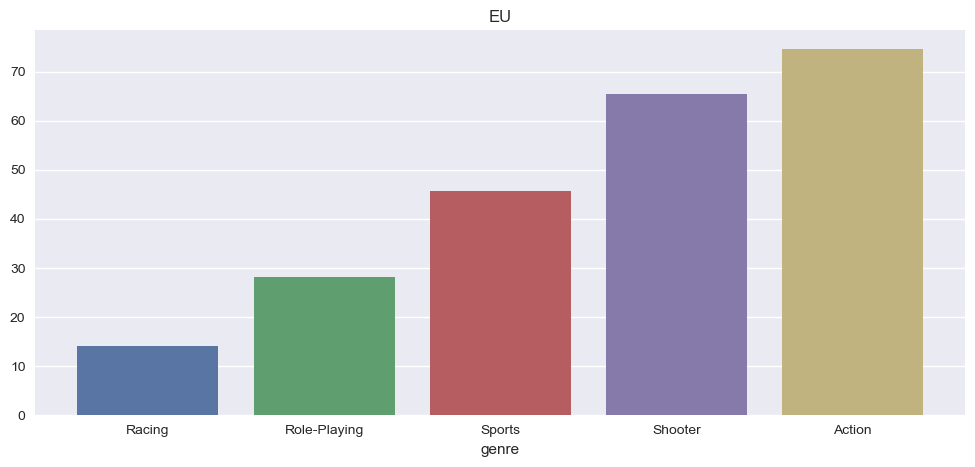

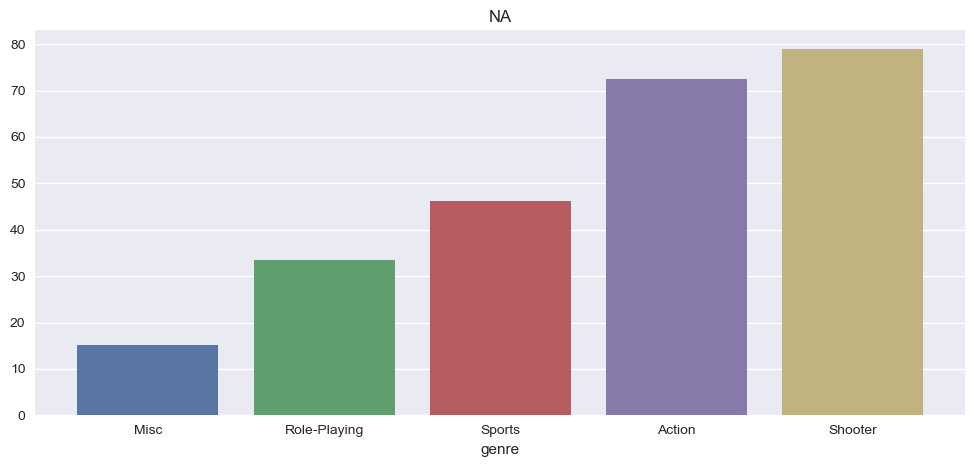

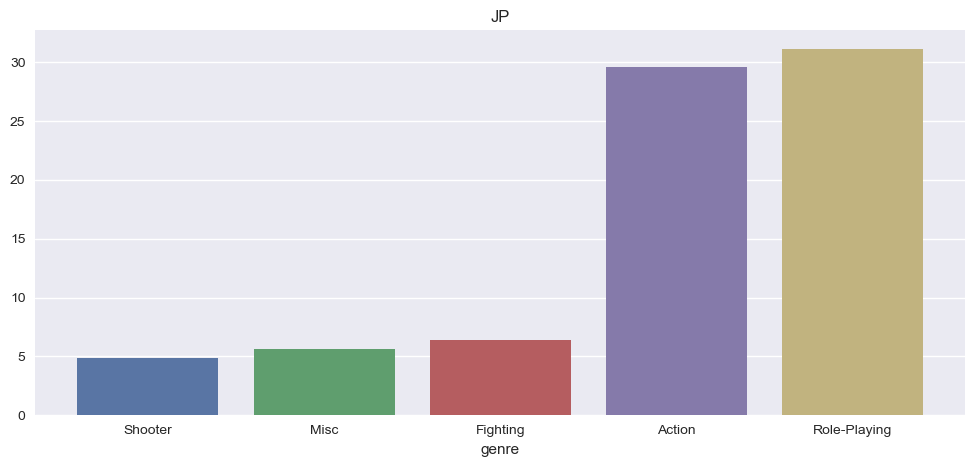

In [59]:
# построим графики по суммарным продажам по регионам
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    temp = actual_data.groupby('genre')[region].sum().sort_values()[-5:]
    
    sns.barplot(
        x=temp.index, y=temp.values,
        order=temp.index
    );

    plt.title(region[:2].upper())
    
    ax.plot();

In [60]:
# функция для того, чтобы добавить точные значения сверху графиков 
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

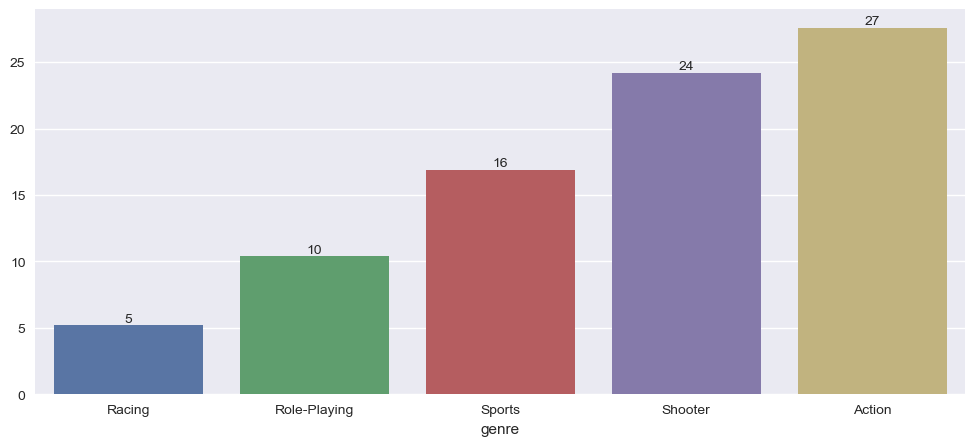

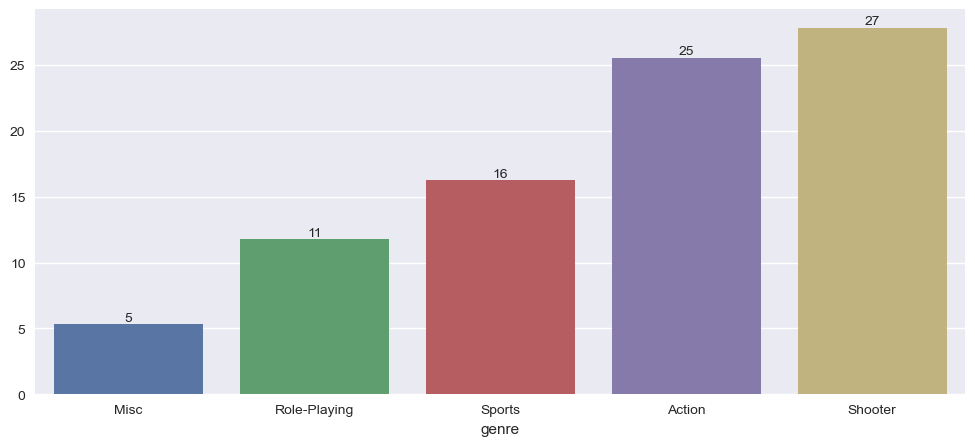

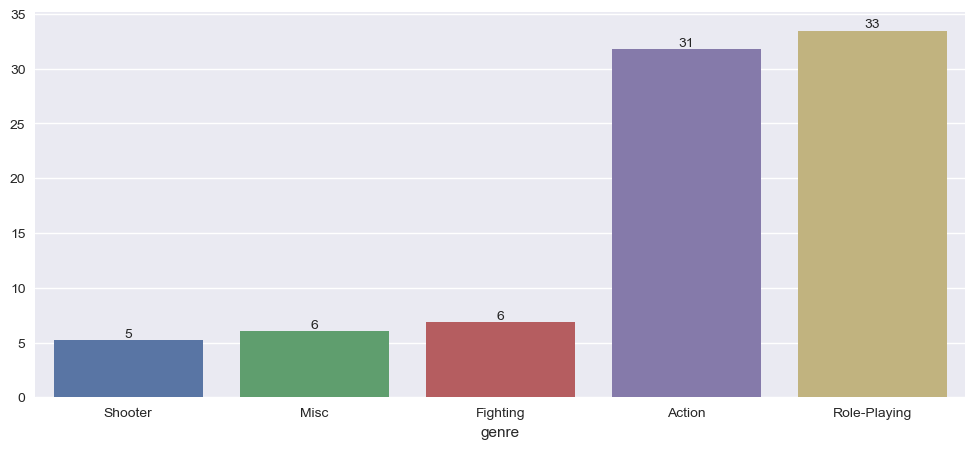

In [61]:
# построим графики по проценту продаж по регионам
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))
    temp = actual_data.groupby('genre')[region].sum().sort_values()[-5:] / actual_data[region].sum() * 100
    
    ax = sns.barplot(
        x=temp.index, y=temp.values,
        order=temp.index
    );
    autolabel(ax.patches, height_factor=1)

Похоже в Европе и Америке играют примерно в одно и то же, но вот в Японии играют в первую очередь в РПГ.

### Рейтинг ESRB

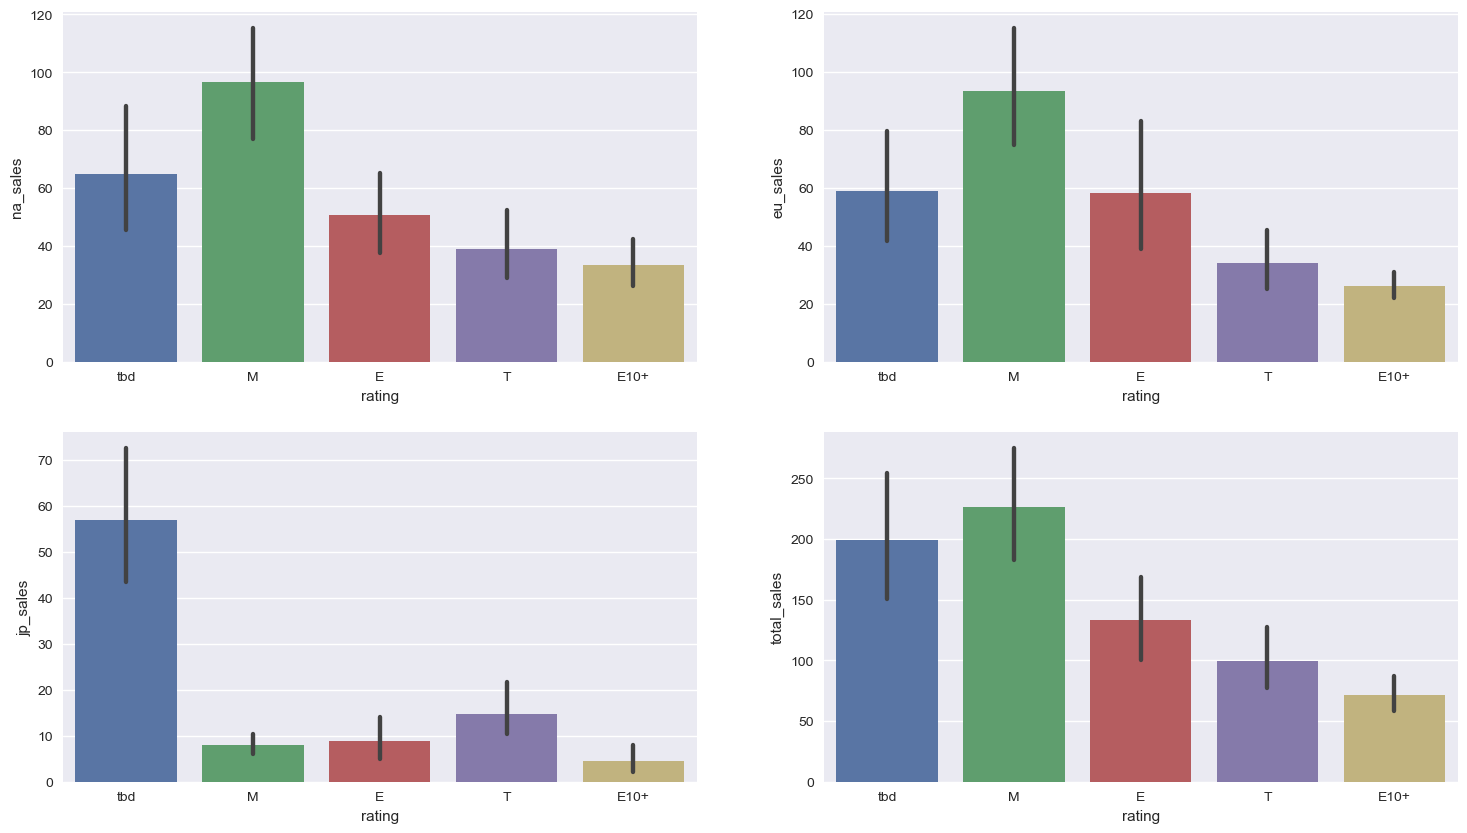

In [62]:
# Графики продаж по возрастному рейтингу игр 
fig, axis = plt.subplots(2,2, figsize=(18,10))
sns.barplot(y='na_sales', x='rating', data = actual_data,estimator=sum, ax=axis[0,0]);
sns.barplot(y='eu_sales', x='rating', data = actual_data,estimator=sum, ax=axis[0,1]);
sns.barplot(y='jp_sales', x='rating', data = actual_data,estimator=sum, ax=axis[1,0]);
sns.barplot(y='total_sales', x='rating', data = actual_data,estimator=sum, ax=axis[1,1]);

Похоже рейтинг рейтинг и правда влияет в зависимости от региона.

Не очень удобно судить по непонятному рейтингу, переведем в что-то более привычное.

In [63]:
actual_data['rating'].unique()

array(['tbd', 'M', 'E', 'T', 'E10+'], dtype=object)

In [64]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 
             'E10+': '>10 лет', 'tbd': 'Не известен'}

actual_data['ESRB_description'] = actual_data['rating'].copy().map(ESRB_dict)

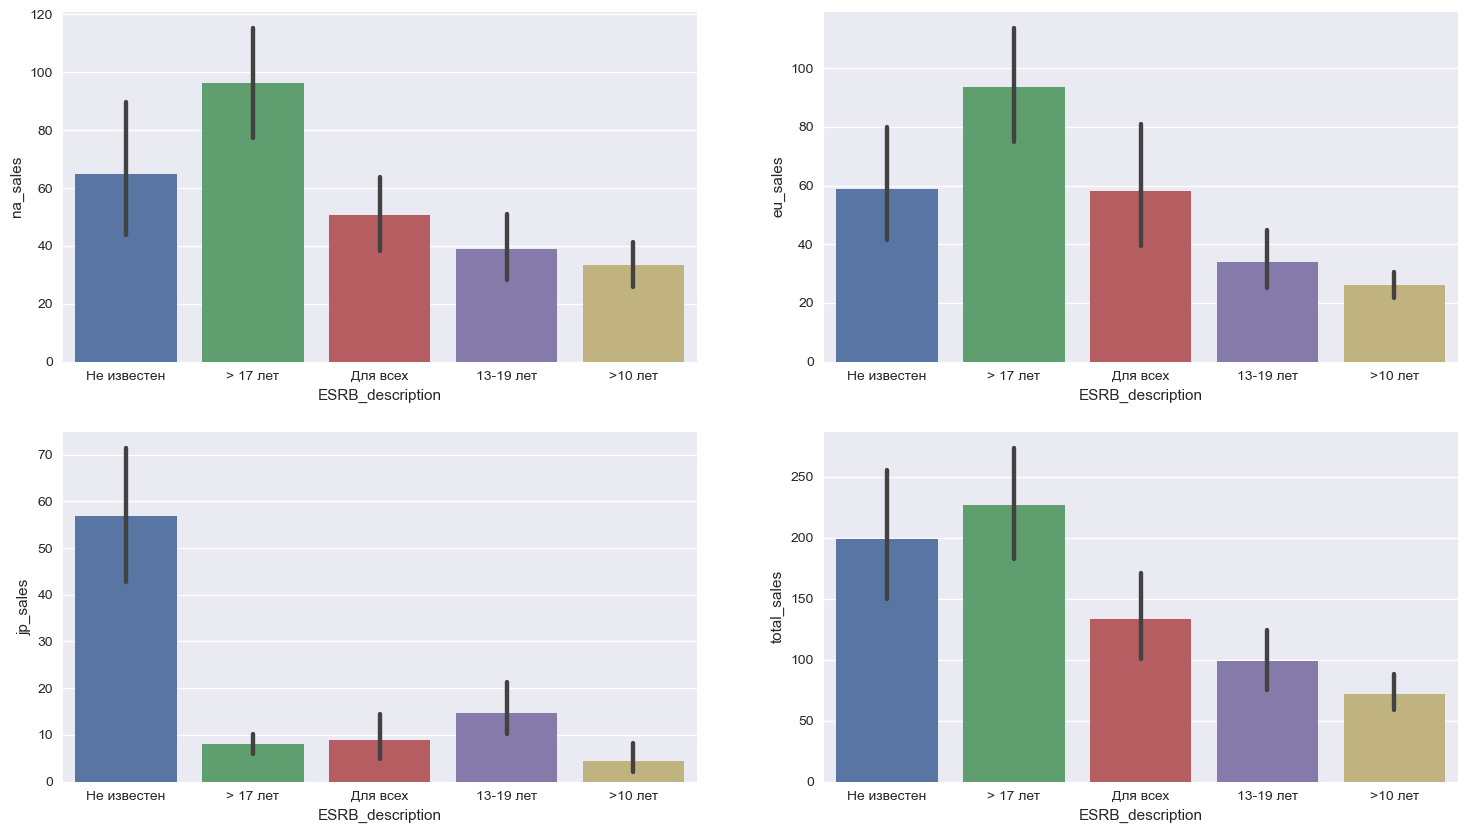

In [65]:
fig, axis = plt.subplots(2,2, figsize=(18,10))
sns.barplot(y='na_sales', x='ESRB_description', data = actual_data,estimator=sum, ax=axis[0,0]);
sns.barplot(y='eu_sales', x='ESRB_description', data = actual_data,estimator=sum, ax=axis[0,1]);
sns.barplot(y='jp_sales', x='ESRB_description', data = actual_data,estimator=sum, ax=axis[1,0]);
sns.barplot(y='total_sales', x='ESRB_description', data = actual_data,estimator=sum, ax=axis[1,1]);

В Европе и Америке в первую очередь продаются игры с рейтингом 17+. В Японии сделать какие-то выводы сложно, потому что очень многие игры не оценены.

## Гипотезы

### Гипотеза №1

*Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые*

Альтернативной гипотезой же будет противоположное условие.

*Н1: Средние пользовательские рейтинги платформ Xbox One и PC различны*

In [66]:
sampl1, sampl2 = (
    actual_data[actual_data['platform'] == 'XOne']['user_score'], 
    actual_data[actual_data['platform'] == 'PC']['user_score']
)

alpha = .05
results = st.ttest_ind(
    sampl1[~sampl1.isna()], sampl2[~sampl2.isna()], equal_var=False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.13167437743832203
Не получилось отвергнуть нулевую гипотезу


### Гипотеза №2

*Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковы*

Альтернативной гипотезой же будет противоположное условие.

*Н1: Средние пользовательские рейтинги жанров Action и Sports разные*

In [67]:
sampl1, sampl2 = (
    actual_data[actual_data['genre'] == 'Action']['user_score'], 
    actual_data[actual_data['genre'] == 'Sports']['user_score']
)

alpha = .05
results = st.ttest_ind(
    sampl1[~sampl1.isna()], sampl2[~sampl2.isna()], equal_var=False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.0065146196426465e-14
Отвергаем нулевую гипотезу


Так как мы взяли за Н0 гипотезу, что рейтинги одинаковы и отверги, значит рейтинги значимо различаются.

## Вывод

Мы исследовали данные по играм до нынешнего года. Мы исследовали зависимость продаж игр от разных факторов.

### По годам

С 94-го года продажи росли вплоть до 2010. Далее появилась тенденция к падению общей прибыли с игр.

### Платформы

В среднем платформы живут 7 лет. То есть стоит искать перспективные платформы, среди тех которым меньше лет 4.

Самыми популярными платформами прошлого поколения показались X360, PS3, Wii. Самыми же перспективными оказались PS4, XOne. Еще можно рассмотреть PC (эту платформу можно считать вечной, на ней играли всегда).

### Игры

Оказывается в Европе и Америке играют в первую очередь в Action, Shooter. В Японии же в первую очередь играю в Role Playing, Action.

Похоже в жанре Action есть несколько игр, которые и забирают всю прибыль. Более перспективным можно считать жанр Shooter, потому что именно в нем медианный заработок игры самый высокий. 

### Регионы

В Европе и Америке играют в первую очередь в игры с рейтингом AO, когда в Японии играют E, T и M. Вероятно это значит, что в первых двух регионах играют в основном взрослые, а в последнем играют люди до 18-ти.

В Европе и Америке в первую очередь продаются игры с рейтингом 17+ и для всех. В Японии сделать какие-то выводы сложно, потому что очень многие игры не оценены.

### Гипотезы

Было выдвинуто 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action и Sports разные

Первую отвергнуть не удалось.

Вторая же похожа на правду. Так как мы взяли за Н0 гипотезу, что рейтинги одинаковы и отверги, значит рейтинги значимо различаются.